In [1]:
import pandas as pd
from typing import List, Tuple, Dict, Optional
import numpy as np
from math import radians,cos,sin,asin,sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as stats
from sklearn.mixture import GaussianMixture
from scipy.optimize import minimize

from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint
from shapely import wkt
from scipy.spatial import ConvexHull

import geopandas as gpd
import rasterio
from rasterio.mask import mask

from pathlib import Path

C:\Users\Yifei\.conda\envs\geo_env\lib\site-packages\geopandas\_compat.py:106: UserWarning: The Shapely GEOS version (3.11.4-CAPI-1.17.4) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


# Visualization

## Figure 1: Null Model
For each slice, produce three side-by-side plots:
* Concurrent duration histogram (sim vs obs)
* Event frequency boxplots for tiger-leading (difference > 0)
* Event frequency boxplots for leopard-leading (difference < 0)

In [9]:
import re
import shutil
from pathlib import Path
from typing import Tuple, Optional

def normalize_mc_padding_inplace(
    base_dir: Path,
    id_pair: Tuple[int,int],
    target_width: int = 3,
    dry_run: bool = False,
) -> None:
    """
    In-place rename of simulated parquet files in base_dir so that 'MC' tokens
    use exactly `target_width` digits (default: 3 → MC001, MC051, MC900).
    Observed files (with 'observed_time') are ignored.
    """
    id1, id2 = id_pair
    patterns = [
        f"{id1}_{id2}_slice*_events_*_MC*.parquet",
        f"{id1}_{id2}_slice*_pairs_*_MC*.parquet",
    ]
    mc_re = re.compile(r"(MC)(\d+)")
    renamed = skipped = 0

    for pat in patterns:
        files = list(base_dir.rglob(pat))
        for src in files:
            stem = src.stem
            m = mc_re.search(stem)
            if not m:
                skipped += 1
                continue
            try:
                mc_val = int(m.group(2))
            except ValueError:
                skipped += 1
                continue
            new_token = f"MC{str(mc_val).zfill(target_width)}"
            new_stem = mc_re.sub(new_token, stem, count=1)
            if new_stem == stem:
                skipped += 1
                continue
            dst = src.with_name(new_stem + src.suffix)
            if not dry_run:
                src.rename(dst)
            renamed += 1

    print(f"[normalize] {base_dir}: renamed={renamed}, skipped={skipped}")

In [10]:
import re, shutil
from pathlib import Path

def copy_and_renumber_mc_files(
    id_pair: Tuple[int,int],
    base_dir1: Path,
    base_dir2: Path,
    offset: int = 0,          # MC_new = MC_old + offset
    max_mc_dir2: int = 1000,    # only copy MC in [1, max_mc_dir2]
    target_width: int = 3,
    dry_run: bool = False,
) -> None:
    """
    Copy simulated parquet files from base_dir2 into base_dir1, renumbering MC by +offset,
    and forcing MC token to exactly `target_width` digits (default 3).
    Reproduces the relative directory structure under base_dir1.
    """
    id1, id2 = id_pair
    patterns = [
        f"{id1}_{id2}_slice*_events_*_MC*.parquet",
        f"{id1}_{id2}_slice*_pairs_*_MC*.parquet",
    ]
    mc_re = re.compile(r"(MC)(\d+)")

    base_dir1.mkdir(parents=True, exist_ok=True)
    if not base_dir2.exists():
        raise FileNotFoundError(f"base_dir2 not found: {base_dir2}")

    copied = skipped_exist = skipped_range = scanned = 0
    for pat in patterns:
        for src in base_dir2.rglob(pat):
            scanned += 1
            stem = src.stem
            m = mc_re.search(stem)
            if not m:
                continue
            try:
                mc_old = int(m.group(2))
            except ValueError:
                continue
            if not (1 <= mc_old <= max_mc_dir2):
                skipped_range += 1
                continue

            mc_new = mc_old + offset
            new_token = f"MC{str(mc_new).zfill(target_width)}"
            new_stem = mc_re.sub(new_token, stem, count=1)
            dst_rel = src.relative_to(base_dir2).with_name(new_stem + src.suffix)
            dst = base_dir1 / dst_rel
            dst.parent.mkdir(parents=True, exist_ok=True)

            if dst.exists():
                skipped_exist += 1
                continue

            if not dry_run:
                shutil.copy2(src, dst)
            copied += 1

    print(f"[copy+renumber] {base_dir2} → {base_dir1}: scanned={scanned}, copied={copied}, skip_exist={skipped_exist}, skip_out_of_range={skipped_range}")

In [11]:
from pathlib import Path
import pandas as pd
from typing import Tuple, Optional, Dict

def summarize_interaction_results(
    id_pair: Tuple[int,int],
    base_dir: Optional[Path] = None,
    bin_labels: Optional[List[str]] = None,
    summary_folder: str = "summary",
    max_mc: int = 100,
    write_out: bool = True,
    verbose: bool = True,
) -> Dict[str, pd.DataFrame]:
    """
    Scan a by-slice directory for simulated vs observed ORTEGA outputs,
    concat them into four DataFrames (with a 'slice' column), optionally write to disk, and return them.
    """
    if bin_labels is None or len(bin_labels) == 0:
        raise ValueError("Please provide bin_labels (e.g., ['0-1d','1-2d','2-4d','4-8d','8-16d','16-21d']).")

    id1, id2 = id_pair
    if base_dir is None:
        base_dir = Path(f"../../simulated_trajectory/CRW_slice_RT_MC50/by_slice_{id1}_{id2}_reverse_time")            
    
    # # file‐patterns
    # patterns = {
    #   "sim_events": f"{id1}_{id2}_slice*_events_*_MC*.parquet",
    #   "sim_pairs" : f"{id1}_{id2}_slice*_pairs_*_MC*.parquet",
    #   "obs_events": f"{id1}_{id2}_slice*_events_*_observed_time.parquet",
    #   "obs_pairs" : f"{id1}_{id2}_slice*_pairs_*_observed_time.parquet",
    # }re
    
    # def load_with_slice(fp: Path) -> pd.DataFrame:
    #     # filename stem like "229032_37821_slice012_events_0-1h_MC001"
    #     stem = fp.stem
    #     # find token "sliceNNN"
    #     slice_tok = next(tok for tok in stem.split("_") if tok.startswith("slice"))
    #     # strip prefix and convert to int
    #     slice_idx = int(slice_tok.replace("slice", ""))
    #     df = pd.read_parquet(fp)
    #     df["slice"] = slice_idx + 1
    #     return df

    # # discover and load
    # dfs: Dict[str, pd.DataFrame] = {}
    # for key, pat in patterns.items():
    #     files = list(base_dir.rglob(pat))
    #     if files:
    #         df_list = [load_with_slice(fp) for fp in files]
    #         dfs[key] = pd.concat(df_list, ignore_index=True)
    #     else:
    #         dfs[key] = pd.DataFrame()

    # if write_out:
    #     out = base_dir / summary_folder
    #     out.mkdir(parents=True, exist_ok=True)
    #     for key, df in dfs.items():
    #         df.to_parquet(out / f"df_{key}.parquet", index=False)

    # for key, df in dfs.items():
    #     print(f"{key}: {len(df)} rows")

    # return dfs    

    # ---- helpers ----
    def _parse_slice_from_path(fp: Path) -> int:
        # filename like "..._slice012_..." -> 12
        stem = fp.stem
        slice_tok = next(tok for tok in stem.split("_") if tok.startswith("slice"))
        return int(slice_tok.replace("slice", ""))

    def _parse_mc_from_path(fp: Path) -> Optional[int]:
        # filename like "..._MC0007" -> 7
        stem = fp.stem
        for tok in stem.split("_"):
            if tok.startswith("MC"):
                try:
                    return int(tok.replace("MC",""))
                except ValueError:
                    return None
        return None

    def _load_obs_with_slice(fp: Path) -> pd.DataFrame:
        df = pd.read_parquet(fp)
        df["slice"] = _parse_slice_from_path(fp) + 1
        return df

    def _load_sim_with_slice_if_within(fp: Path) -> Optional[pd.DataFrame]:
        mc = _parse_mc_from_path(fp)
        if mc is None or mc > max_mc:
            return None
        df = pd.read_parquet(fp)
        df["slice"] = _parse_slice_from_path(fp) + 1
        # ensure MC_round exists & matches parsed integer
        if "MC_round" not in df.columns:
            df["MC_round"] = mc
        else:
            # overwrite to be safe; keeps your downstream grouping stable
            df["MC_round"] = mc
        return df

    def _collect_for_labels(pattern_fmt: str, labels: List[str]) -> List[Path]:
        files: List[Path] = []
        for lbl in labels:
            pat = pattern_fmt.format(lbl=lbl)
            files.extend(base_dir.rglob(pat))
        return files

    # ---------- build file lists restricted to bin_labels ----------
    sim_events_files = _collect_for_labels(
        f"{id1}_{id2}_slice*_events_{{lbl}}_MC*.parquet", bin_labels
    )
    sim_pairs_files  = _collect_for_labels(
        f"{id1}_{id2}_slice*_pairs_{{lbl}}_MC*.parquet", bin_labels
    )
    obs_events_files = _collect_for_labels(
        f"{id1}_{id2}_slice*_events_{{lbl}}_observed_time.parquet", bin_labels
    )
    obs_pairs_files  = _collect_for_labels(
        f"{id1}_{id2}_slice*_pairs_{{lbl}}_observed_time.parquet", bin_labels
    )

    # ---------- discover + load ----------
    dfs: Dict[str, pd.DataFrame] = {}

    # simulated (filter to first max_mc)
    parts = []
    for fp in sim_events_files:
        d = _load_sim_with_slice_if_within(fp)
        if d is not None:
            parts.append(d)
    dfs["sim_events"] = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()

    parts = []
    for fp in sim_pairs_files:
        d = _load_sim_with_slice_if_within(fp)
        if d is not None:
            parts.append(d)
    dfs["sim_pairs"] = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()

    # observed (no MC filter)
    parts = [_load_obs_with_slice(fp) for fp in obs_events_files] if obs_events_files else []
    dfs["obs_events"] = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()

    parts = [_load_obs_with_slice(fp) for fp in obs_pairs_files] if obs_pairs_files else []
    dfs["obs_pairs"] = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()

    # ---------- write out ----------
    if write_out:
        out = base_dir / summary_folder
        out.mkdir(parents=True, exist_ok=True)
        for key, df in dfs.items():
            df.to_parquet(out / f"df_{key}.parquet", index=False)

    # ---------- quick counts ----------
    if verbose:
        for key, df in dfs.items():
            if key.startswith("sim") and not df.empty and "MC_round" in df.columns:
                uniq_mc = sorted(pd.unique(df["MC_round"]))
                mc_info = f" | MC kept: {len(uniq_mc)} (min={min(uniq_mc)}, max={max(uniq_mc)})"
            else:
                mc_info = ""
            print(f"{key}: {len(df)} rows{mc_info}")

    return dfs

In [12]:
_mc_re = re.compile(r"(MC)(\d+)")
def _parse_slice_from_path(fp: Path) -> int:
    # ..._slice012_... -> 12 (0-based in your earlier utilities; keep consistent)
    stem = fp.stem
    tok = next(t for t in stem.split("_") if t.startswith("slice"))
    return int(tok.replace("slice", ""))

def _parse_mc_from_path(fp: Path) -> Optional[int]:
    stem = fp.stem
    for tok in stem.split("_"):
        if tok.startswith("MC"):
            try:
                return int(tok.replace("MC",""))
            except ValueError:
                return None
    return None

def _replace_timebin_in_name(fp: Path, new_label: str) -> Path:
    """Swap the time-bin token in the filename to new_label."""
    parts = fp.stem.split("_")
    # filename structure like: id1_id2_sliceXXX_(events|pairs)_{timebin}_MC#### or ..._observed_time
    # Find the token right after events|pairs
    for i, t in enumerate(parts):
        if t in ("events", "pairs"):
            # next token is the timebin, replace it
            parts[i+1] = new_label
            break
    return fp.with_name("_".join(parts) + fp.suffix)

def _merge_touching_events(df: pd.DataFrame, tol_seconds: int = 0) -> pd.DataFrame:
    """
    Merge adjacent events when previous end == current start for BOTH individuals.
    Assumes columns: p1, p2, p1_start, p1_end, p2_start, p2_end (datetime-like or str)
    """
    if df.empty:
        return df

    # ensure datetimes
    for col in ["p1_start","p1_end","p2_start","p2_end"]:
        if not np.issubdtype(df[col].dtype, np.datetime64):
            df[col] = pd.to_datetime(df[col], errors="coerce")

    df = df.sort_values(["p1","p2","p1_start","p2_start","p1_end","p2_end"]).reset_index(drop=True)

    out_rows = []
    cur = None
    tol = pd.Timedelta(seconds=tol_seconds)

    for _, row in df.iterrows():
        if cur is None:
            cur = row.copy()
            continue

        same_pair = (row["p1"] == cur["p1"]) and (row["p2"] == cur["p2"])
        touch_p1 = abs((row["p1_start"] - cur["p1_end"])) <= tol
        touch_p2 = abs((row["p2_start"] - cur["p2_end"])) <= tol

        if same_pair and touch_p1 and touch_p2:
            # extend current event
            cur["p1_end"] = max(cur["p1_end"], row["p1_end"])
            cur["p2_end"] = max(cur["p2_end"], row["p2_end"])
        else:
            out_rows.append(cur)
            cur = row.copy()

    if cur is not None:
        out_rows.append(cur)

    merged = pd.DataFrame(out_rows).reset_index(drop=True)

    # recompute duration metrics if you keep them (optional)
    # Example: total overlap minutes based on p1 timeline (or min of ends - max of starts)
    if "difference" in merged.columns:
        merged = merged.drop(columns=["difference"])
    merged["difference"] = (merged["p2_start"] - merged["p1_start"]).dt.total_seconds() / 60.0

    return merged

def _concat_pairs(files: List[Path]) -> pd.DataFrame:
    dfs = []
    for fp in files:
        d = pd.read_parquet(fp)
        dfs.append(d)
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

def _concat_events(files: List[Path]) -> pd.DataFrame:
    dfs = []
    for fp in files:
        d = pd.read_parquet(fp)
        dfs.append(d)
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

def scan_slices_and_mcs(
    id_pair: Tuple[int,int],
    base_dir: Path
) -> Tuple[List[int], List[int]]:
    """
    Find all slice indices and MC ids that exist for sub-day files.
    Returns (sorted_slices, sorted_mcs). Either may be empty.
    """
    id1, id2 = id_pair

    # build patterns WITHOUT regex alternation (glob can't do (events|pairs))
    patt_mc_events = [f"{id1}_{id2}_slice*_events_{lab}_MC*.parquet"  for lab in SUBDAY_LABELS]
    patt_mc_pairs  = [f"{id1}_{id2}_slice*_pairs_{lab}_MC*.parquet"   for lab in SUBDAY_LABELS]
    patt_obs_events= [f"{id1}_{id2}_slice*_events_{lab}_observed_time.parquet" for lab in SUBDAY_LABELS]
    patt_obs_pairs = [f"{id1}_{id2}_slice*_pairs_{lab}_observed_time.parquet"  for lab in SUBDAY_LABELS]

    def collect(patterns: List[str]) -> List[Path]:
        out = []
        for pat in patterns:
            out.extend(base_dir.rglob(pat))
        return out

    mc_files  = collect(patt_mc_events) + collect(patt_mc_pairs)
    obs_files = collect(patt_obs_events) + collect(patt_obs_pairs)

    slices, mcs = set(), set()

    for fp in mc_files:
        try:
            s = _parse_slice_from_path(fp)
            m = _parse_mc_from_path(fp)
        except StopIteration:
            continue
        if s is not None: slices.add(s)
        if m is not None: mcs.add(m)

    for fp in obs_files:
        try:
            s = _parse_slice_from_path(fp)
        except StopIteration:
            continue
        if s is not None: slices.add(s)

    return sorted(slices), sorted(mcs)

    
def combine_subday_bins_to_one_day_batched(
    id_pair: Tuple[int,int],
    base_dir: Path,
    batch_size: int = 50,
    dry_run: bool = False,
    tol_seconds: int = 0,
    verbose: bool = True,
) -> Dict[str, int]:
    """
    Same logic as before, but:
      - Detects (slices, MCs) present first
      - Iterates in order (slice asc, MC asc)
      - Buffers outputs and writes every `batch_size` files
    """
    id1, id2 = id_pair

    # Build lookups for quick file grouping
    def collect(patterns: List[str]) -> List[Path]:
        res = []
        for pat in patterns:
            res.extend(base_dir.rglob(pat))
        return res

    patt_mc_events = [f"{id1}_{id2}_slice*_events_{lab}_MC*.parquet"  for lab in SUBDAY_LABELS]
    patt_mc_pairs  = [f"{id1}_{id2}_slice*_pairs_{lab}_MC*.parquet"   for lab in SUBDAY_LABELS]
    patt_obs_events= [f"{id1}_{id2}_slice*_events_{lab}_observed_time.parquet" for lab in SUBDAY_LABELS]
    patt_obs_pairs = [f"{id1}_{id2}_slice*_pairs_{lab}_observed_time.parquet"  for lab in SUBDAY_LABELS]

    files_mc_events = collect(patt_mc_events)
    files_mc_pairs  = collect(patt_mc_pairs)
    files_obs_events= collect(patt_obs_events)
    files_obs_pairs = collect(patt_obs_pairs)

    # Group to dicts
    def key_mc(fp: Path):  return (_parse_slice_from_path(fp), _parse_mc_from_path(fp))
    def key_obs(fp: Path): return (_parse_slice_from_path(fp), "observed")

    grp_mc_events: Dict[tuple, List[Path]] = {}
    grp_mc_pairs : Dict[tuple, List[Path]] = {}
    grp_obs_events: Dict[tuple, List[Path]] = {}
    grp_obs_pairs : Dict[tuple, List[Path]] = {}

    for fp in files_mc_events: grp_mc_events.setdefault(key_mc(fp), []).append(fp)
    for fp in files_mc_pairs:  grp_mc_pairs.setdefault(key_mc(fp), []).append(fp)
    for fp in files_obs_events:grp_obs_events.setdefault(key_obs(fp), []).append(fp)
    for fp in files_obs_pairs: grp_obs_pairs.setdefault(key_obs(fp), []).append(fp)

    # Detect present slices and MCs
    slices, mcs = scan_slices_and_mcs(id_pair, base_dir)
    if verbose:
        if slices:
            slice_span = f"{min(slices)}–{max(slices)}"
        else:
            slice_span = "none"
    
        if mcs:
            mc_span = f"{min(mcs)}–{max(mcs)}"
            print(f"[scan] slices: {len(slices)} ({slice_span}), MCs: {len(mcs)} ({mc_span})")
        else:
            print(f"[scan] slices: {len(slices)} ({slice_span}), MCs: none (observed only?)")
    
    # Optional: bail early with a clearer message
    if not slices and not mcs:
        raise FileNotFoundError(
            f"No sub-day files found for pair {id_pair} under {base_dir}. "
            f"Checked labels: {SUBDAY_LABELS}"
        )


    # Write buffer
    buffer: List[Tuple[pd.DataFrame, Path, str]] = []  # (df, sample_fp, kind)
    written = 0
    skipped = 0

    def enqueue_write(df: pd.DataFrame, sample_fp: Path, kind: str):
        nonlocal skipped
        if df is None or df.empty:
            skipped += 1
            return
        out_fp = _replace_timebin_in_name(sample_fp, NEW_LABEL)
        buffer.append((df, out_fp, kind))

    def flush():
        nonlocal written
        if dry_run or not buffer:
            # nothing to write or dry-run just clears buffer
            buffer.clear()
            return
        for df, out_fp, kind in buffer:
            out_fp.parent.mkdir(parents=True, exist_ok=True)
            df.to_parquet(out_fp, index=False)
            if verbose:
                print(f"[write] {kind}: {out_fp}")
        written += len(buffer)
        buffer.clear()

    # ---- MC paths: iterate ordered (slice, MC) ----
    for s in slices:
        for m in mcs:
            k = (s, m)
            fl_pairs = grp_mc_pairs.get(k, [])
            fl_events= grp_mc_events.get(k, [])
            if not fl_pairs and not fl_events:
                continue

            # pairs: concat and tag
            if fl_pairs:
                dfp = _concat_pairs(sorted(fl_pairs))
                if not dfp.empty:
                    dfp["time_bin"] = NEW_LABEL
                enqueue_write(dfp, sorted(fl_pairs)[0], "pairs")

            # events: concat, merge touching, tag
            if fl_events:
                dfe = _concat_events(sorted(fl_events))
                if not dfe.empty:
                    dfe["time_bin"] = NEW_LABEL
                    dfe = _merge_touching_events(dfe, tol_seconds=tol_seconds)
                enqueue_write(dfe, sorted(fl_events)[0], "events")

            if len(buffer) >= batch_size:
                flush()

    # ---- Observed paths: iterate ordered by slice ----
    for s in slices:
        k = (s, "observed")
        fl_pairs = grp_obs_pairs.get(k, [])
        fl_events= grp_obs_events.get(k, [])
        if not fl_pairs and not fl_events:
            continue

        if fl_pairs:
            dfp = _concat_pairs(sorted(fl_pairs))
            if not dfp.empty:
                dfp["time_bin"] = NEW_LABEL
            enqueue_write(dfp, sorted(fl_pairs)[0], "pairs")

        if fl_events:
            dfe = _concat_events(sorted(fl_events))
            if not dfe.empty:
                dfe["time_bin"] = NEW_LABEL
                dfe = _merge_touching_events(dfe, tol_seconds=tol_seconds)
            enqueue_write(dfe, sorted(fl_events)[0], "events")

        if len(buffer) >= batch_size:
            flush()

    # final flush
    flush()

    if verbose:
        print(f"[combine_subday_bins_to_one_day_batched] base={base_dir} | written_files={written}, skipped_empty={skipped}")
    return {"written_files": written, "skipped_empty": skipped}


In [13]:
from scipy.stats import mannwhitneyu
from typing import List, Tuple, Dict, Any

def compute_pvalues_duration(
    df_sim: pd.DataFrame,
    df_obs: pd.DataFrame,
    slices: List[str],
    time_bin: str
) -> pd.DataFrame:
    """
    For each slice, compares total duration per MC_run vs observed total duration
    using Mann-Whitney U (two-sided).
    
    H0: The distribution of simulated total durations equals the degenerate
        distribution at the observed total duration.
    H1: They differ in median.
    """
    rows: List[Dict[str, Any]] = []
    for sl in slices:
        # simulated total duration per MC_run
        sim = df_sim[(df_sim['slice']==sl) & (df_sim['time_bin']==time_bin)]
        sim_sums = sim.groupby('MC_round')['duration'].sum().values

        # skip if no simulated runs
        if len(sim_sums) == 0:
            continue
        
        # observed total duration (default to 0 if no column or no rows)
        if 'duration' in df_obs.columns:
            obs = df_obs[(df_obs['slice']==sl) & (df_obs['time_bin']==time_bin)]
            obs_sum = obs['duration'].sum()  # zero if none
            obs_count = len(obs)  # zero if none
        else:
            obs_sum = 0.0
            obs_count = 0
        
        # build obs_array of same length
        obs_array = np.full(len(sim_sums), obs_sum)
        
        # Mann-Whitney U test
        U, p = mannwhitneyu(sim_sums, obs_array, alternative='two-sided')
        
        rows.append({
            'slice': sl,
            'time_bin': time_bin,
            'sim_sums': np.median(sim_sums),
            'obs_sum': obs_sum,
            'obs_count': obs_count,
            'U': U,
            'p_value': p,
            'significant': (p < 0.05)
        })
    return pd.DataFrame(rows)

In [14]:
def compute_pvalues_duration_empirical(
    df_sim: pd.DataFrame,
    df_obs: pd.DataFrame,
    slices: List[str],
    time_bin: str,
    tail: str = "greater"
) -> pd.DataFrame:
    """
    For each slice, compares total duration per MC_run vs observed total duration
    using an empirical p-value.

    tail:
      - "greater": p = P(sim_sums >= obs_sum)
      - "less":    p = P(sim_sums <= obs_sum)
      - "two-sided": p = P(|sim_sums - median(sim_sums)| >= |obs_sum - median(sim_sums)|)
    """
    rows: List[Dict[str, Any]] = []
    for sl in slices:
        # simulated total duration per MC_run
        sim = df_sim[(df_sim['slice']==sl) & (df_sim['time_bin']==time_bin)]
        sim_sums = sim.groupby('MC_round')['duration'].sum().values

        # skip if no simulated runs
        if len(sim_sums) == 0:
            continue
        
        # observed total duration (default to 0 if no column or no rows)
        if 'duration' in df_obs.columns:
            obs = df_obs[(df_obs['slice']==sl) & (df_obs['time_bin']==time_bin)]
            obs_sum = obs['duration'].sum()  # zero if none
            obs_count = len(obs)  # zero if none
        else:
            obs_sum = 0.0
            obs_count = 0
        
        n = len(sim_sums)
        if tail == "greater":
            k = np.count_nonzero(sim_sums >= obs_sum)
            p = (k + 1) / (n + 1)
        elif tail == "less":
            k = np.count_nonzero(sim_sums <= obs_sum)
            p = (k + 1) / (n + 1)
        else:  # two-sided
            med = np.median(sim_sums)
            diffs = np.abs(sim_sums - med)
            obs_diff = abs(obs_sum - med)
            k = np.count_nonzero(diffs >= obs_diff)
            p = (k + 1) / (n + 1)
        
        rows.append({
            'slice': sl,
            'time_bin': time_bin,
            'sim_median': np.median(sim_sums),
            'obs_sum': obs_sum,
            'obs_count': obs_count,
            'p_value': p,
            'significant': (p < 0.05)
        })
        
    return pd.DataFrame(rows)

In [15]:
def compute_pvalues_event_counts_by_leader(
    df_sim: pd.DataFrame,
    df_obs: pd.DataFrame,
    slices: List[str],
    bin_labels: List[str]
) -> pd.DataFrame:
    """
    Computes Mann-Whitney U p-values per slice, time_bin, and leader category
    comparing simulated counts (per MC_round) vs observed counts.

    Adds a 'leader' column with values 'tiger_leading' or 'leopard_leading'.
    """
    rows: List[Dict[str, Any]] = []
    for sl in slices:
        for lbl in bin_labels:
            for leader, condition in [
                ('tiger_leading', lambda df: df['difference'] > 0),
                ('leopard_leading', lambda df: df['difference'] < 0)
            ]:
                # Filter simulated and observed by slice, bin, and leader condition
                sim_sel = df_sim[
                    (df_sim['slice'] == sl) &
                    (df_sim['time_bin'] == lbl) &
                    condition(df_sim)
                ]
                sim_counts = sim_sel.groupby('MC_round').size().values

                # Skip if no simulated runs for this leader category
                if len(sim_counts) == 0:
                    continue

                obs_sel = df_obs[
                    (df_obs['slice'] == sl) &
                    (df_obs['time_bin'] == lbl) &
                    condition(df_obs)
                ]
                obs_count = len(obs_sel)

                # Create obs_array (allows obs_count==0)
                obs_array = np.full(len(sim_counts), obs_count)

                # Mann-Whitney U test
                U, p = mannwhitneyu(sim_counts, obs_array, alternative='two-sided')

                rows.append({
                    'slice': sl,
                    'time_bin': lbl,
                    'leader': leader,
                    'n_sim': len(sim_counts),
                    'n_obs': obs_count,
                    'U': U,
                    'p_value': p,
                    'significant': (p < 0.05)
                })

    return pd.DataFrame(rows)

In [16]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from typing import List, Tuple, Union, Sequence

def plot_slicewise_threepanel(
    df_sim_events: pd.DataFrame,
    df_obs_events: pd.DataFrame,
    id_pair: Tuple[int,int],
    bin_labels: List[str],
    concurrent_bin: str = "0-1h",
    slices: Union[None, Sequence[str]] = None,
    bins: int = 20,
    figsize_per_row: Tuple[int,int] = (9, 3),
    title_fs: int = 14,
    label_fs: int = 12,
    tick_fs: int = 10,
    star_fs: int = 40,
    legend_fs: int = 12
):
    """
    For each slice, produce three side-by-side plots:
      1) Concurrent duration histogram (sim vs obs)
      2) Event frequency boxplots for tiger-leading (difference > 0)
      3) Event frequency boxplots for leopard-leading (difference < 0)

    Parameters
    ----------
    df_sim_events : DataFrame with ['slice','time_bin','MC_round','duration','difference']
    df_obs_events : DataFrame with ['slice','time_bin','duration','difference']
    id_pair : (id1,id2)
    bin_labels : ordered list of time-bin labels for the boxplots
    concurrent_bin : time-bin for the duration histogram
    slices : list of slice labels; defaults to sorted unique df_sim_events['slice']
    bins : number of bins for histogram
    figsize_per_row : tuple (width, height) per row
    """
    if slices is None:
        slices = sorted(df_sim_events['slice'].unique())

    # Precompute all p-values
    # pv_dur = compute_pvalues_duration(df_sim_events, df_obs_events, slices, concurrent_bin)
    pv_dur = compute_pvalues_duration_empirical(df_sim_events, df_obs_events, slices, concurrent_bin)
    print(pv_dur)
    pv_evt = compute_pvalues_event_counts_by_leader(df_sim_events, df_obs_events, slices, bin_labels)
    print(pv_evt)

    # delayed bins (exclude concurrent) for panels 2 & 3
    delayed_labels = [lbl for lbl in bin_labels if lbl != concurrent_bin]

    n = len(slices)
    ind = np.arange(len(delayed_labels))
    width = 0.35
    
    fig, axes = plt.subplots(n, 3,
                             figsize=(3*figsize_per_row[0], n*figsize_per_row[1]),
                             squeeze=False)
    
    id1, id2 = id_pair

    # 3) Precompute histogram y-limit
    hist_maxes = []
    for s0 in slices:
        # get the sim sums
        sim_con = (
            df_sim_events
            .loc[(df_sim_events['slice']==s0) & (df_sim_events['time_bin']==concurrent_bin)]
            .groupby('MC_round')['duration']
            .sum()
        )
        if not sim_con.empty:
            counts, _ = np.histogram(sim_con, bins=bins)
            hist_maxes.append(counts.max())
    
    # now take the overall max + a little padding
    hist_ymax = max(hist_maxes) * 1.05 if hist_maxes else 1

    # 4) Precompute boxplot y-limit
    box_counts_all = []
    for s0 in slices:
        # tiger
        mask_ts = ((df_sim_events['slice']==s0) & (df_sim_events['difference']>0))
        g_t = (
            df_sim_events[mask_ts]
            .groupby(['time_bin','MC_round'])
            .size()
        )
        box_counts_all.extend(g_t.values.tolist())
        # obs tiger
        for lbl in delayed_labels:
            box_counts_all.append(
                len(df_obs_events.loc[
                    (df_obs_events['slice']==s0) &
                    (df_obs_events['difference']>0) &
                    (df_obs_events['time_bin']==lbl)
                ])
            )
        # leopard
        mask_ls = ((df_sim_events['slice']==s0) & (df_sim_events['difference']<0))
        g_l = (
            df_sim_events[mask_ls]
            .groupby(['time_bin','MC_round'])
            .size()
        )
        box_counts_all.extend(g_l.values.tolist())
        # obs leopard
        for lbl in delayed_labels:
            box_counts_all.append(
                len(df_obs_events.loc[
                    (df_obs_events['slice']==s0) &
                    (df_obs_events['difference']<0) &
                    (df_obs_events['time_bin']==lbl)
                ])
            )
    box_ymax = max(box_counts_all)*1.05 if box_counts_all else 1

    # 5) Global histogram x‐limit
    all_maxes = []
    for s0 in slices:
        sim_con = (
            df_sim_events
            .loc[(df_sim_events['slice']==s0) & (df_sim_events['time_bin']==concurrent_bin)]
            .groupby('MC_round')['duration']
            .sum()
        )
        if not sim_con.empty:
            all_maxes.append(sim_con.max())
        if 'duration' in df_obs_events.columns:
            mask_obs = (
                (df_obs_events['slice']    == s0) &
                (df_obs_events['time_bin'] == concurrent_bin)
            )
            obs_values = df_obs_events.loc[mask_obs, 'duration']
            obs_sum = obs_values.sum() if not obs_values.empty else 0.0
        else:
            obs_sum = 0.0
    
        all_maxes.append(obs_sum)
    global_max = max(all_maxes) if all_maxes else 0
    xlim = (0, global_max*1.05)
    

    for i, sl in enumerate(slices):
        ax0, ax1, ax2 = axes[i]

        # --------------------------------------------------
        # 1) Concurrent duration histogram
        sim_con = df_sim_events[(df_sim_events['slice']==sl) & (df_sim_events['time_bin']==concurrent_bin)]
        sim_con_sum = sim_con.groupby('MC_round')['duration'].sum()
        # safe observed duration
        if 'duration' in df_obs_events.columns:
            mask_obs = (
                (df_obs_events['slice']    == sl) &
                (df_obs_events['time_bin'] == concurrent_bin)
            )
            obs_values = df_obs_events.loc[mask_obs, 'duration']
            obs_con_sum = obs_values.sum() if not obs_values.empty else 0.0
        else:
            obs_con_sum = 0.0
        
        ax0.hist(sim_con_sum, bins=bins, alpha=0.7, edgecolor='k', color='#986eac', label='Sim')
        ax0.axvline(obs_con_sum, color='C1', lw=2, label='Obs')
        ax0.set_title(f"Partition {sl}\nConcurrent Duration", fontsize=title_fs)
        ax0.set_xlabel("Duration (min)", fontsize=label_fs)
        ax0.set_ylabel("Count", fontsize=label_fs)
        ax0.tick_params(labelsize=tick_fs)
        ax0.set_xlim(-10, xlim[1])
        ax0.set_ylim(0, hist_ymax)

        if i == 0:
            ax0.legend(loc='upper right', fontsize=legend_fs)
            
        # annotate star if significant
        row_d = pv_dur[pv_dur['slice']==sl]
        if not row_d.empty and row_d.iloc[0]['significant']:
            ax0.text(0.02, 0.95, '*', transform=ax0.transAxes,
                     fontsize=star_fs, color='red', va='top', ha='left',
                    fontweight='bold', zorder=10)

        # --------------------------------------------------
        # Prepare count data for boxplots
        def prepare_counts(df, leader_cond):
            sel = df[(df['slice']==sl) & leader_cond(df)]
            counts = sel.groupby(['time_bin','MC_round']).size().reset_index(name='count')
            return [counts.loc[counts['time_bin']==lbl, 'count'].values for lbl in delayed_labels]

        sim_data_t = prepare_counts(df_sim_events,  lambda df: df['difference'] > 0)
        obs_counts_t = df_obs_events[(df_obs_events['slice']==sl) & (df_obs_events['difference'] > 0)]
        obs_data_t = [np.array([len(obs_counts_t[obs_counts_t['time_bin']==lbl])]) for lbl in delayed_labels]

        sim_data_l = prepare_counts(df_sim_events,  lambda df: df['difference'] < 0)
        obs_counts_l = df_obs_events[(df_obs_events['slice']==sl) & (df_obs_events['difference'] < 0)]
        obs_data_l = [np.array([len(obs_counts_l[obs_counts_l['time_bin']==lbl])]) for lbl in delayed_labels]

        # # y-limit
        # all_counts = np.hstack([
        #     np.hstack(sim_data_t) if len(sim_data_t)>0 else [0],
        #     np.hstack(obs_data_t),
        #     np.hstack(sim_data_l) if len(sim_data_l)>0 else [0],
        #     np.hstack(obs_data_l)
        # ])
        # ymax = max(all_counts.max()* 1.05, 1)

        # --------------------------------------------------
        # 2) Tiger-leading boxplots (difference > 0)
        ax1.boxplot(sim_data_t, positions=ind-width/2, widths=width,
                    patch_artist=True, boxprops=dict(facecolor='#686EE2', edgecolor='k'),
                   medianprops=dict(color='k'))
        ax1.boxplot(obs_data_t, positions=ind+width/2, widths=width,
                    patch_artist=True, boxprops=dict(facecolor='C1', edgecolor='k'))
        ax1.set_title(f"Partition {sl} Leopard-following\nEvent Frequency", fontsize=title_fs)
        ax1.set_ylim(-10, box_ymax)
        ax1.set_xticks(ind)
        ax1.set_xticklabels(delayed_labels, rotation=45, ha='right')
        ax1.set_xlabel("Time lag", fontsize=label_fs)
        ax1.set_ylabel("Frequency", fontsize=label_fs)
        ax1.tick_params(labelsize=tick_fs)
        if i == 0:
            legend_handles = [Patch(facecolor='#0072b2', edgecolor='k', label='Sim'),
                              Line2D([0], [0], color='C1', lw=2, label='Obs')]
            ax1.legend(handles=legend_handles, loc='upper right', fontsize=legend_fs)

        # annotate stars per bin
        for j, lbl in enumerate(delayed_labels):
            pv_row = pv_evt[
                (pv_evt['slice']==sl) &
                (pv_evt['time_bin']==lbl) &
                (pv_evt['leader']=='tiger_leading')
            ]
            if not pv_row.empty and pv_row.iloc[0]['significant']:
                # place star just above the highest box
                ax1.text(ind[j], box_ymax*0.83, '*',
                         ha='center', va='bottom', fontsize=star_fs, color='red',
                        fontweight='bold', zorder=10)
            
        # --------------------------------------------------
        # 3) Leopard-leading boxplots (difference < 0)        
        ax2.boxplot(sim_data_l, positions=ind-width/2, widths=width,
                    patch_artist=True, boxprops=dict(facecolor='#F35C6E', edgecolor='k'),
                   medianprops=dict(color='k'))
        ax2.boxplot(obs_data_l, positions=ind+width/2, widths=width,
                    patch_artist=True, boxprops=dict(facecolor='C1', edgecolor='k'))
        ax2.set_title(f"Partition {sl} Tiger-following\nEvent Frequency ", fontsize=title_fs)
        ax2.set_ylim(-10, box_ymax)
        ax2.set_xticks(ind)
        ax2.set_xticklabels(delayed_labels, rotation=45, ha='right')
        ax2.set_xlabel("Time lag", fontsize=label_fs)
        ax2.tick_params(labelsize=tick_fs)
        if i == 0:
            legend_handles = [Patch(facecolor='#d55e00', edgecolor='k', label='Sim'),
                              Line2D([0], [0], color='C1', lw=2, label='Obs')]
            ax2.legend(handles=legend_handles, loc='upper right', fontsize=legend_fs)

        # annotate stars per bin
        for j, lbl in enumerate(delayed_labels):
                pv_row = pv_evt[
                    (pv_evt['slice']==sl) &
                    (pv_evt['time_bin']==lbl) &
                    (pv_evt['leader']=='leopard_leading')
                ]
                if not pv_row.empty and pv_row.iloc[0]['significant']:
                    ax2.text(ind[j], box_ymax*0.83, '*',
                             ha='center', va='bottom', fontsize=star_fs, color='red',
                            fontweight='bold', zorder=10)

    plt.tight_layout()
    # plt.savefig(f"../../figure/{id_pair[0]}_{id_pair[1]}_null_model_star.jpg", dpi=500, bbox_inches='tight')
    plt.savefig(f"../../figure/{id_pair[0]}_{id_pair[1]}_null_model_star.jpg", dpi=500, bbox_inches='tight')
    # plt.show()
    return plt

In [17]:
import re
from pathlib import Path
from typing import Tuple, List, Optional, Dict
import pandas as pd
import numpy as np

id_pair = (229032, 37821)
# id_pair = (131343, 37821)
id1, id2 = id_pair
SUBDAY_LABELS = ["1-3h","3-6h","6-12h","12-24h"]
NEW_LABEL = "1h-1d"
base = Path(f"../../simulated_trajectory/CRW_slice_RT_MC50/by_slice_{id1}_{id2}_reverse_time")
# combine_subday_bins_to_one_day_batched(id_pair, base, batch_size=50, dry_run=False, tol_seconds=1, verbose=True)

In [18]:
id_pair = (229032, 37821)
# bin_labels = ["0-1h","1-3h","3-6h","6-12h","12-24h","1-2d","2-4d","4-8d","8-16d", "16-21d"]
# time_bins   = [0, 60, 180, 360, 720, 1440, 2880, 5760, 11520, 23040, 30240]
bin_labels = ["0-1h", "1h-1d","1-2d","2-4d","4-8d","8-16d", "16-21d"]
time_bins   = [0, 60, 1440, 2880, 5760, 11520, 23040, 30240]
id1, id2 = id_pair
base_dir1 = Path(f"../../simulated_trajectory/CRW_slice_RT_MC50/by_slice_{id1}_{id2}_reverse_time")            
# base_dir2 = Path(f"../../simulated_trajectory/CRW_slice_RT_MC2000/by_slice_{id1}_{id2}_reverse_time")            

In [19]:
# normalize_mc_padding_inplace(base_dir1, id_pair, target_width=3, dry_run=False)
# normalize_mc_padding_inplace(base_dir2, id_pair, target_width=3, dry_run=False)

In [20]:
# copy_and_renumber_mc_files(
#     id_pair=id_pair,
#     base_dir1 = base_dir1,
#     base_dir2 = base_dir2,
#     offset=50,          # base_dir1 has MC001..MC050; dir2 MC001..MC850 → MC051..MC900
#     max_mc_dir2=850,    # only take first 850 from dir2
#     dry_run=False       # set True first if you want to preview actions
# )

In [21]:
results = summarize_interaction_results(id_pair, bin_labels = bin_labels, max_mc = 50)
df_sim_events = results["sim_events"]
df_sim_pairs = results["sim_pairs"]
df_obs_events = results["obs_events"]
df_obs_pairs = results["obs_pairs"]

slices = sorted(df_sim_events['slice'].unique())

sim_events: 60859 rows | MC kept: 50 (min=1, max=50)
sim_pairs: 151368 rows | MC kept: 50 (min=1, max=50)
obs_events: 2736 rows
obs_pairs: 11909 rows


In [22]:
print(sorted(df_sim_pairs['time_bin'].unique()))
print(max(sorted(df_sim_events['MC_round'])))

['0-1h', '1-2d', '16-21d', '1h-1d', '2-4d', '4-8d', '8-16d']
50


   slice time_bin  sim_median  obs_sum  obs_count   p_value  significant
0      1     0-1h  122.716667      0.0          0  1.000000        False
1      2     0-1h  186.975000    780.0          4  0.027027         True
2      3     0-1h  148.950000    180.0          1  0.375000        False
3      4     0-1h  226.866667   5281.0         23  0.021739         True
    slice time_bin           leader  n_sim  n_obs       U       p_value  \
0       1     0-1h    tiger_leading     10      0   100.0  2.428175e-05   
1       1     0-1h  leopard_leading     21      0   441.0  5.634889e-10   
2       1    1h-1d    tiger_leading     42      1  1722.0  4.562266e-16   
3       1    1h-1d  leopard_leading     47      0  2209.0  4.254786e-19   
4       1     1-2d    tiger_leading     41     19   123.0  1.128570e-12   
5       1     1-2d  leopard_leading     37      1  1295.0  4.375590e-13   
6       1     2-4d    tiger_leading     40     55     0.0  1.909692e-16   
7       1     2-4d  leopard_leading

<module 'matplotlib.pyplot' from 'C:\\Users\\Yifei\\.conda\\envs\\geo_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

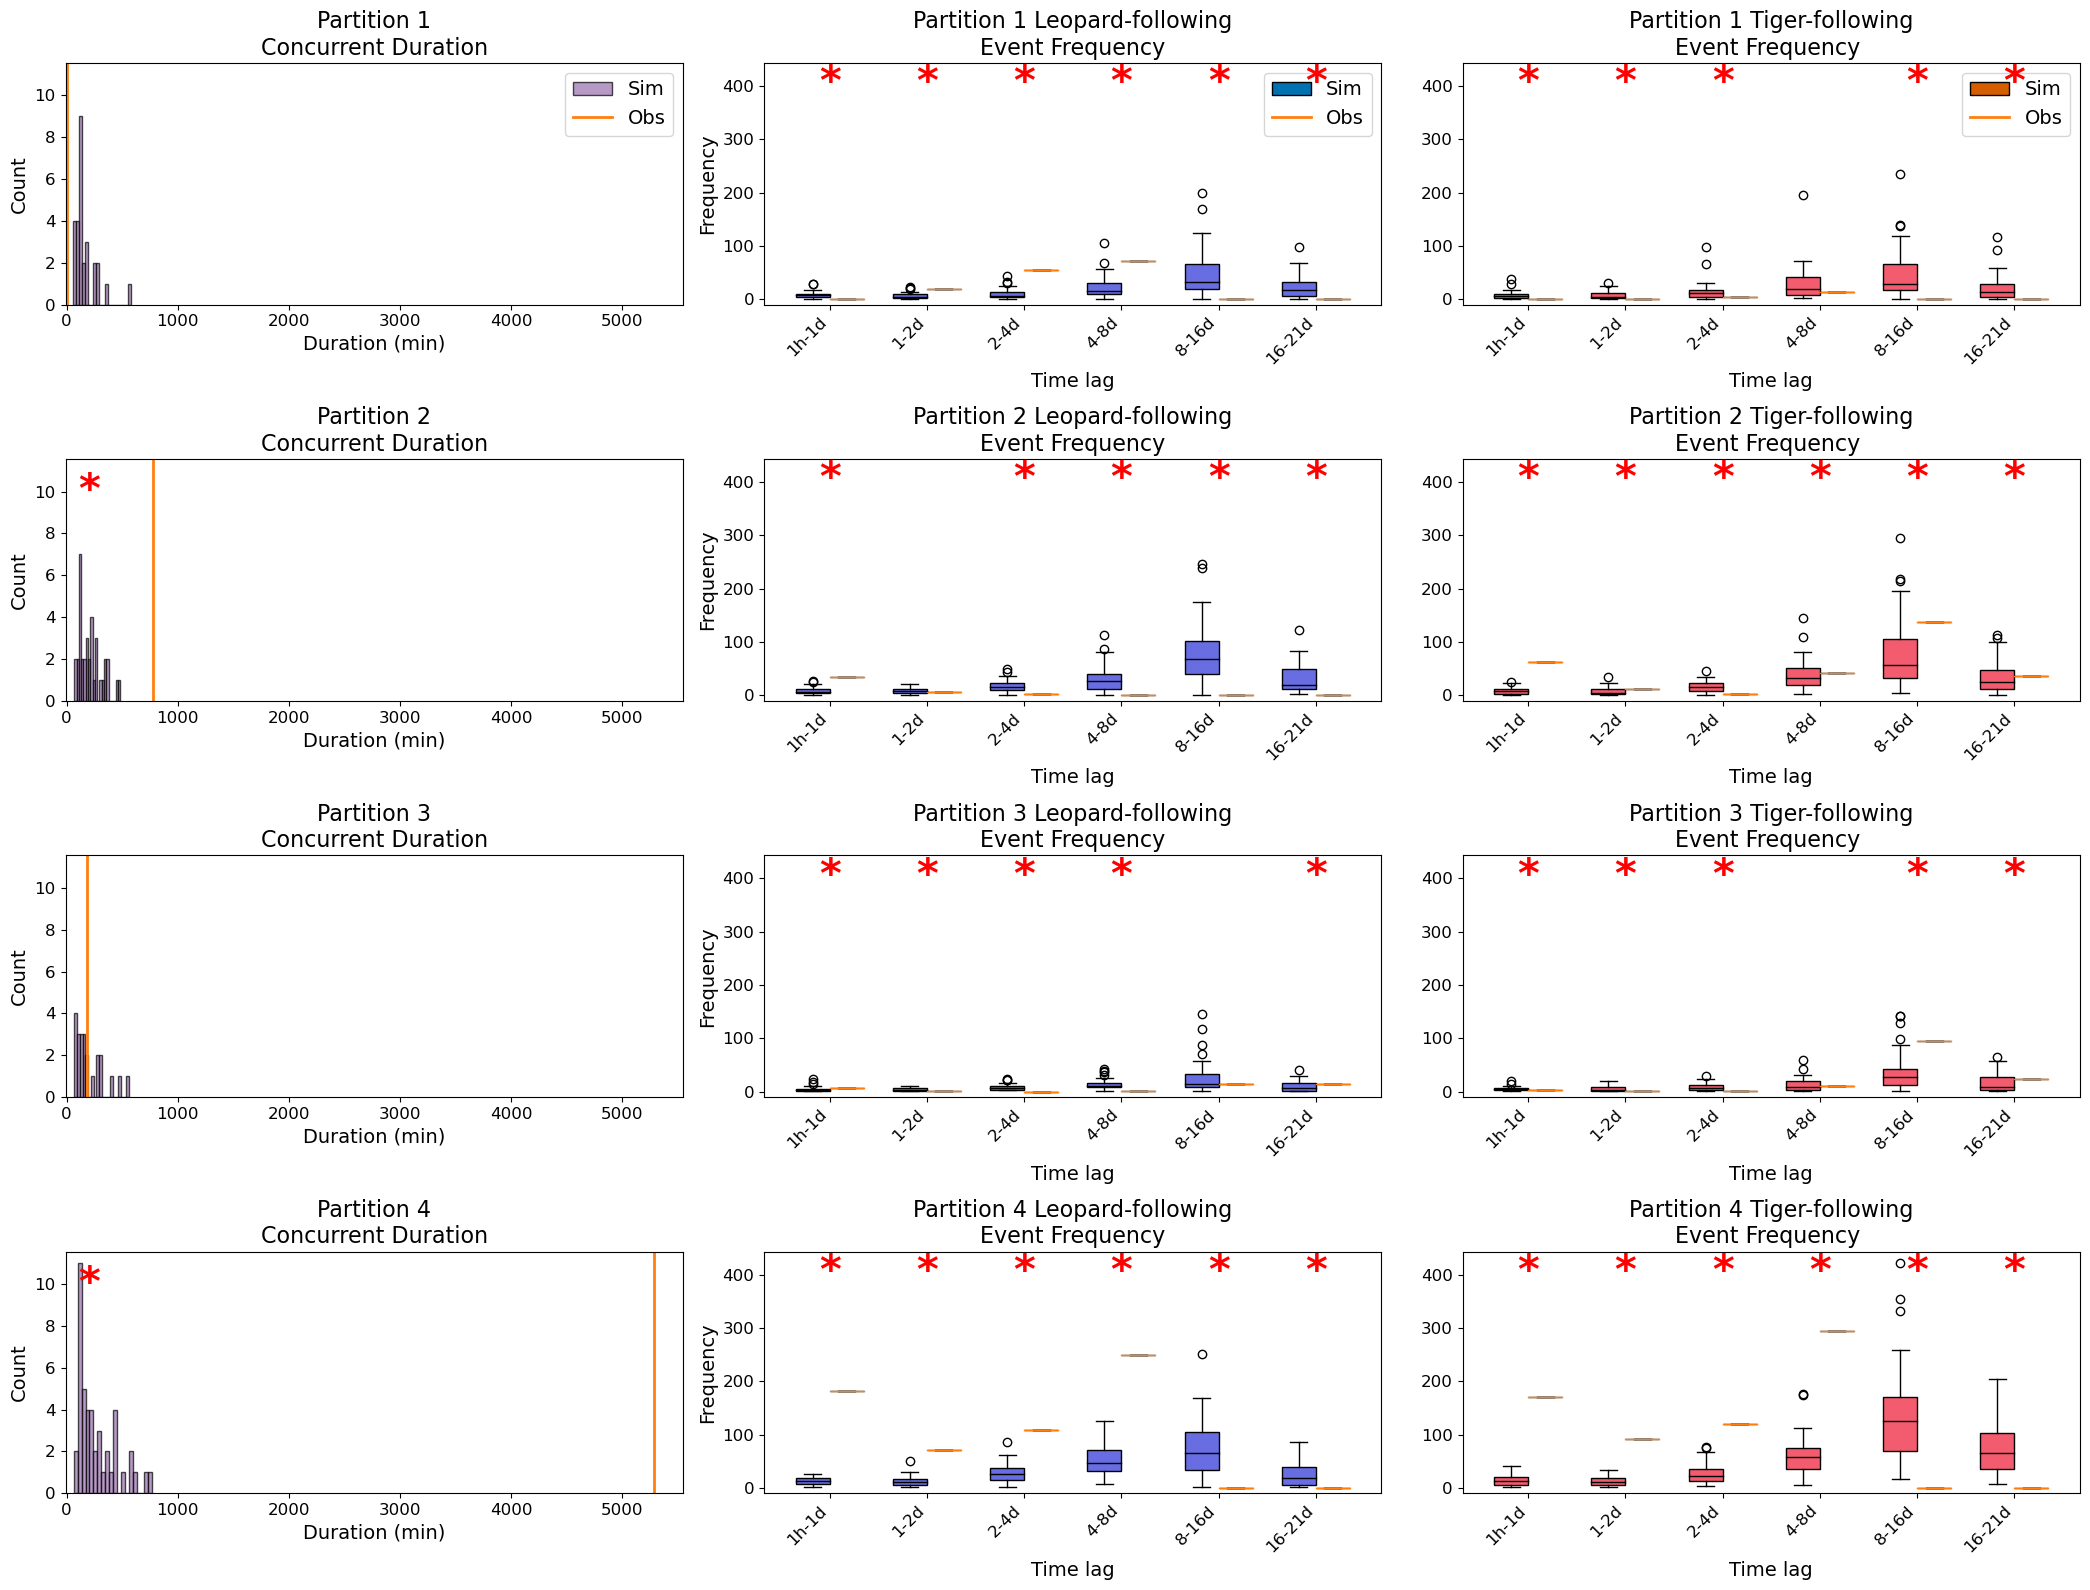

In [23]:
plot_slicewise_threepanel(
    df_sim_events,
    df_obs_events,
    id_pair,
    bin_labels,
    "0-1h",
    slices,
    bins=20,
    figsize_per_row=(7,4),
    title_fs=16, label_fs=14, tick_fs=12, star_fs=30, legend_fs=14
)

## Figure 2: Home Range, Tracking Data Density and Number

In [24]:
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from datetime import timedelta
from typing import List, Tuple

In [25]:
def extract_adjusted_tracking_data(file_path, id_pair, output_path):
    """
    Extracts the tracking data within the adjusted shared timeline.
    - Keeps three weeks before the shared start time for early starters (if possible).
    - Keeps three weeks after the shared end time for late finishers (if possible).
    - If the time difference is less than three weeks, keeps the original data.
    """
    # Load the dataset
    df = pd.read_csv(file_path)

    # Convert time column to datetime format
    df['Time_LMT'] = pd.to_datetime(df['Time_LMT'])

    # Filter for the selected individuals
    df_pair = df[df['idcollar'].isin(id_pair)].copy()

    # Find the earliest and latest tracking times for each individual
    earliest_times = df_pair.groupby('idcollar')['Time_LMT'].min()
    latest_times = df_pair.groupby('idcollar')['Time_LMT'].max()

    # Determine the shared start and end times
    shared_earliest_time = earliest_times.max()
    shared_latest_time = latest_times.min()

    # Apply a three-week buffer for early starters
    adjusted_start_times = {}
    for id in id_pair:
        individual_start = earliest_times[id]
        if (shared_earliest_time - individual_start) > pd.Timedelta(weeks=0):
            adjusted_start_times[id] = shared_earliest_time - pd.Timedelta(weeks=0)
        else:
            adjusted_start_times[id] = individual_start  # Keep original if within three weeks

    # Apply a three-week buffer for late finishers
    adjusted_end_times = {}
    for id in id_pair:
        individual_end = latest_times[id]
        if (individual_end - shared_latest_time) > pd.Timedelta(weeks=0):
            adjusted_end_times[id] = shared_latest_time + pd.Timedelta(weeks=0)
        else:
            adjusted_end_times[id] = individual_end  # Keep original if within three weeks

    # Extract rows within the adjusted timeline for each individual
    df_filtered = pd.concat([
        df_pair[(df_pair['idcollar'] == id) &
                (df_pair['Time_LMT'] >= adjusted_start_times[id]) &
                (df_pair['Time_LMT'] <= adjusted_end_times[id])]
        for id in id_pair
    ])

    # Sort by time for proper sequence
    df_filtered = df_filtered.sort_values(by=['Time_LMT'])

    # Save the extracted dataset
    df_filtered[['idcollar', 'Time_LMT', 'proj_lon', 'proj_lat', 'slope', 'sb', 'bt', 'gr']].to_csv(
        output_path, index=False
    )

    print(f"Extracted tracking data saved to {output_path}")

    return df_filtered  # Return the filtered DataFrame

In [26]:
def compute_slice_home_ranges(
    file_path: str,
    id_pairs: List[Tuple[int,int]],
    adjusted_dir: str,
    window_hours: int = 1000,
    utm_epsg: int = 32647
)-> Tuple[gpd.GeoDataFrame, gpd.GeoDataFrame]:
    """
    For each pair in id_pairs:
      1) Runs extract_adjusted_tracking_data into adjusted_dir
      2) Loads and renames columns
      3) Splits into reverse-time windows of window_hours
      4) Computes per-idcollar:
         - number of points
         - 95% MCP area (km2) and polygon
      5) Computes overlapped MCP area for the two individuals (km2)
    Returns GeoDataFrame with columns:
      pair_id, idcollar, slice, start, end,
      n_points, area_km2, overlapped_area_km2, geometry
    """
    records = []

    for id1, id2 in id_pairs:
        pair_id = f"{id1}_{id2}"
        adj_csv = os.path.join(adjusted_dir, f"adjusted_timeline_{id1}_{id2}.csv")

        # 1) extract & save adjusted timeline
        df_full = extract_adjusted_tracking_data(file_path, [id1, id2], adj_csv)
        # 2) preprocess
        df_full["time"] = pd.to_datetime(df_full["Time_LMT"], errors="coerce")
        df_full = df_full.rename(columns={"idcollar": "idcollar"})

        # 3) build reverse-time windows
        start, end = df_full["time"].min(), df_full["time"].max()
        window = timedelta(hours=window_hours)
        rev = []
        cur_end = end
        while True:
            cur_start = cur_end - window
            if cur_start < start:
                break
            rev.append((cur_start, cur_end))
            cur_end = cur_start
        windows = list(reversed(rev))

        # 4) convert to GeoDataFrame & project
        gdf = gpd.GeoDataFrame(
            df_full,
            geometry=gpd.points_from_xy(df_full["longitude"], df_full["latitude"]),
            crs="EPSG:4326"
        ).to_crs(epsg=utm_epsg)

        # 5) loop slices
        for slice_idx, (w0, w1) in enumerate(windows):
            df_slice = gdf[(gdf["time"]>=w0)&(gdf["time"]<w1)]
            if df_slice.empty:
                continue

            # Compute each individual's MCP in this slice
            mcp_polys = {}
            counts     = {}
            for indiv in (id1, id2):
                pts = df_slice[df_slice["idcollar"]==indiv]
                n_pts = len(pts)
                if n_pts < 3:
                    mcp_polys[indiv] = None
                    counts[indiv]    = n_pts
                    continue

                # 95% MCP
                cen    = pts.unary_union.centroid
                pts["dist"] = pts.geometry.distance(cen)
                thresh = pts["dist"].quantile(0.95)
                core   = pts[pts["dist"] <= thresh]
                poly   = core.unary_union.convex_hull
                mcp_polys[indiv] = poly
                counts[indiv]    = n_pts

            # Compute overlapped area if both MCPs exist
            if mcp_polys[id1] and mcp_polys[id2]:
                overlap = mcp_polys[id1].intersection(mcp_polys[id2])
                overlapped_area = overlap.area / 1e6
            else:
                overlapped_area = 0.0

            # 6) emit one record per individual, carrying overlap area
            for indiv in (id1, id2):
                poly = mcp_polys[indiv]
                if poly is None:
                    continue
                records.append({
                    "pair_id":            pair_id,
                    "idcollar":           indiv,
                    "slice":              slice_idx + 1,
                    "start":              w0,
                    "end":                w1,
                    "n_points":           counts[indiv],
                    "area_km2":           poly.area / 1e6,
                    "overlapped_area_km2": overlapped_area,
                    "geometry":           poly
                })

    # assemble GeoDataFrame
    result = gpd.GeoDataFrame(records, crs=gdf.crs)
    return result

In [27]:
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from datetime import timedelta
from typing import List, Tuple

def compute_slice_home_ranges_with_points(
    file_path: str,
    id_pairs: List[Tuple[int,int]],
    adjusted_dir: str,
    window_hours: int = 1000,
    utm_epsg: int = 32647
) -> Tuple[gpd.GeoDataFrame, gpd.GeoDataFrame]:
    """
    Extends compute_slice_home_ranges:
      - Returns two GeoDataFrames:
        1) MCP boundaries per (pair, indiv, slice)
        2) Tracking points per (pair, indiv, slice)
    """
    boundary_records = []
    point_records = []

    for id1, id2 in id_pairs:
        pair_id = f"{id1}_{id2}"
        adj_csv = os.path.join(adjusted_dir, f"adjusted_timeline_{id1}_{id2}.csv")
        df_full = extract_adjusted_tracking_data(file_path, [id1, id2], adj_csv)
        df_full["time"] = pd.to_datetime(df_full["Time_LMT"], errors="coerce")
        # windows
        start, end = df_full["time"].min(), df_full["time"].max()
        window = timedelta(hours=window_hours)
        rev, cur_end = [], end
        while True:
            cur_start = cur_end - window
            if cur_start < start: break
            rev.append((cur_start, cur_end))
            cur_end = cur_start
        windows = list(reversed(rev))
        # project points
        gdf = gpd.GeoDataFrame(
            df_full, geometry=gpd.points_from_xy(df_full["longitude"], df_full["latitude"]),
            crs="EPSG:4326"
        ).to_crs(epsg=utm_epsg)
        for slice_idx, (w0, w1) in enumerate(windows):
            df_slice = gdf[(gdf["time"]>=w0)&(gdf["time"]<w1)]
            if df_slice.empty: continue
            # record points
            for _, row in df_slice.iterrows():
                point_records.append({
                    "pair_id": pair_id,
                    "idcollar": row["idcollar"],
                    "slice": slice_idx + 1,
                    "geometry": row.geometry
                })
            # compute MCP per individual
            mcp_polys, counts = {}, {}
            for indiv in (id1, id2):
                pts = df_slice[df_slice["idcollar"]==indiv]
                n_pts = len(pts)
                counts[indiv] = n_pts
                if n_pts < 3:
                    mcp_polys[indiv] = None
                    counts[indiv]    = n_pts
                    continue
                # 95% MCP
                cen = pts.unary_union.centroid
                pts["dist"] = pts.geometry.distance(cen)
                core = pts[pts["dist"] <= pts["dist"].quantile(0.95)]
                poly = core.unary_union.convex_hull
                mcp_polys[indiv] = poly
                counts[indiv]    = n_pts
            # Compute overlapped area if both MCPs exist
            overlap = None
            if mcp_polys[id1] and mcp_polys[id2]:
                overlap = mcp_polys[id1].intersection(mcp_polys[id2])
                overlapped_area = overlap.area / 1e6
            else:
                overlapped_area = 0.0

            # 6) emit one record per individual, carrying overlap area
            for indiv in (id1, id2):
                poly = mcp_polys[indiv]
                if poly is None: continue
                boundary_records.append({
                    "pair_id": pair_id,
                    "idcollar": indiv,
                    "slice": slice_idx + 1,
                    "start": w0,
                    "end": w1,
                    "n_points": counts[indiv],
                    "area_km2": poly.area / 1e6,
                    "overlapped_area_km2": overlapped_area,
                    "geometry": poly
                })
    

    boundary_gdf = gpd.GeoDataFrame(boundary_records, crs=gdf.crs)
    point_gdf = gpd.GeoDataFrame(point_records, crs=gdf.crs)
    return boundary_gdf, point_gdf

In [28]:
def integrate_event_counts(
    df_obs_events: pd.DataFrame,
    gdf_slices,                # GeoDataFrame with columns ['pair_id','slice',...]
    time_bins: List[str]
):
    # 1) Normalize slice strings to ints (e.g. 'slice000' -> 0)
    df = df_obs_events.copy()
    if df['slice'].dtype == object:
        df['slice'] = df['slice'].str.replace(r'^slice', '', regex=True).astype(int) + 1

    # 2) Build pair_id column matching gdf_slices
    df['pair_id'] = df['p1'].astype(str) + '_' + df['p2'].astype(str)

    # 3) Count events per (pair_id, slice, time_bin)
    grp = (
        df
        .groupby(['pair_id','slice','time_bin'])
        .size()
        .reset_index(name='n_events')
    )

    # 4) Cross-join gdf_slices with time_bins
    base = gdf_slices.reset_index(drop=True)
    # create a DataFrame of time_bins
    tb_df = pd.DataFrame({'time_bin': time_bins})
    # cross-join
    base['key'] = 1
    tb_df['key']   = 1
    expanded = base.merge(tb_df, on='key').drop('key', axis=1)

    # 5) Align dtypes
    expanded['slice']    = expanded['slice'].astype(grp['slice'].dtype)
    expanded['time_bin'] = expanded['time_bin'].astype(grp['time_bin'].dtype)
    expanded['pair_id']  = expanded['pair_id'].astype(grp['pair_id'].dtype)

    # 6) Merge counts
    merged = (
        expanded
        .merge(grp, on=['pair_id','slice','time_bin'], how='left')
        .fillna({'n_events': 0})
    )
    merged['n_events'] = merged['n_events'].astype(int)

    # 7) Restore geometry column as GeoDataFrame
    import geopandas as gpd
    gdf_merged = gpd.GeoDataFrame(merged, geometry='geometry', crs=gdf_slices.crs)

    return gdf_merged

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import contextily as ctx
from scipy.stats import gaussian_kde
from shapely.geometry import Point
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrow
from matplotlib_scalebar.scalebar import ScaleBar  # requires matplotlib_scalebar package
from typing import Tuple

def plot_slices_hr_kde_grid(
    boundary_gdf: gpd.GeoDataFrame,
    point_gdf: gpd.GeoDataFrame,
    id_pair: Tuple[int,int],
    padding_frac: float = 0.05,
    kde_grid_size: int = 100
):
    """
    For each slice of a given pair, subplot:
      - MCP boundary (red vs blue outline)
      - KDE of points for each individual, clipped to that individual's MCP polygon
      - Shared dynamic grid (2-4 cols based on slice count)
      - Per-panel 2 km scale bar and north arrow
      - Basemap from OpenStreetMap (fallback to gray)
      - Legend of individuals in upper right
    """
    id1, id2 = id_pair
    label1 = idcollar_mapping.get(str(id1), str(id1))
    label2 = idcollar_mapping.get(str(id2), str(id2))
    pair = f"{id1}_{id2}"

    # Project to WebMercator for consistent meters units
    b3857 = boundary_gdf.to_crs(epsg=3857)
    p3857 = point_gdf.to_crs(epsg=3857)

    # global bounds
    all_polys = b3857.query("pair_id==@pair")['geometry']
    if all_polys.empty:
        raise ValueError(f"No MCP data for pair {pair}")
    minx, miny, maxx, maxy = all_polys.unary_union.bounds
    # Add a bit of padding
    pad_x = (maxx - minx) * padding_frac
    pad_y = (maxy - miny) * padding_frac
    minx, maxx = minx - pad_x, maxx + pad_x
    miny, maxy = miny - pad_y, maxy + pad_y

    # Unique slices for this pair
    slices = sorted(b3857.query("pair_id==@pair")['slice'].unique())
    n_slices = len(slices)
    if n_slices == 0:
        raise ValueError(f"No data for pair {pair}")

    # Determine columns: <=16→4, <=25→5, else→6
    if n_slices <= 16:
        n_cols = 4
    elif n_slices <= 25:
        n_cols = 5
    else:
        n_cols = 6
    n_rows = int(np.ceil(n_slices / n_cols))

    # Set up figure
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(5*n_cols, 5*n_rows),
        constrained_layout=True
    )
    axes = axes.flatten()

    # outline colors and colormaps
    outline = {
        id1: ('red',  'Reds'),
        id2: ('blue', 'Blues')
    }

    # Pre-build the evaluation grid for KDE
    xi, yi = np.mgrid[minx:maxx:kde_grid_size*1j, miny:maxy:kde_grid_size*1j]
    coords = np.vstack([xi.ravel(), yi.ravel()])

    for ax, sl in zip(axes, slices):
        # Select slice data
        b = b3857.query("pair_id==@pair and slice==@sl")
        p = p3857.query("pair_id==@pair and slice==@sl")
        if b.empty:
            ax.set_visible(False)
            continue

        # Per-slice MCPs
        row1 = b[b["idcollar"] == id1]
        row2 = b[b["idcollar"] == id2]
        poly1 = row1.geometry.values[0] if not row1.empty else None
        poly2 = row2.geometry.values[0] if not row2.empty else None

        # dict for convenience
        polys = {id1: poly1, id2: poly2}

        # Set up axis
        ax.set_facecolor('#f0f0f0')
        ax.set_xlim(minx-1000, maxx+1000)
        ax.set_ylim(miny-1000, maxy+1000)
        ax.set_aspect('equal', adjustable='box')

        # Try basemap
        try:
            ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
        except Exception:
            pass

        # --- TWO KDEs: one per individual, clipped to its own MCP ---
        n1 = len(p[p["idcollar"] == id1])
        n2 = len(p[p["idcollar"] == id2])

        for this_id in [id1, id2]:
            pts = p[p["idcollar"] == this_id]

            if len(pts) < 5:
                continue  # need enough points for smooth KDE

            kde = gaussian_kde(
                np.vstack([pts.geometry.x.values, pts.geometry.y.values])
            )
            zi = kde(coords).reshape(xi.shape)

            poly = polys[this_id]
            if poly is not None and not poly.is_empty:
                mask = np.array(
                    [poly.contains(Point(x, y)) for x, y in zip(coords[0], coords[1])]
                ).reshape(xi.shape)
                zi = np.ma.masked_where(~mask, zi)

            cmap = outline[this_id][1]  # 'Reds' or 'Blues'
            # lower alpha so overlap is still readable
            ax.contourf(xi, yi, zi, levels=12, cmap=cmap, alpha=0.45, zorder=1)

        # Plot MCP outlines (red & blue)
        if poly1 is not None:
            row1.plot(ax=ax, facecolor="none", edgecolor=outline[id1][0],
                      linewidth=2, zorder=3)
        if poly2 is not None:
            row2.plot(ax=ax, facecolor="none", edgecolor=outline[id2][0],
                      linewidth=2, zorder=3)

        # Legend (counts)
        legend_handles = [
            Line2D([0], [0], color=outline[id1][0], lw=3, label=f"{label1} (n={n1})"),
            Line2D([0], [0], color=outline[id2][0], lw=3, label=f"{label2} (n={n2})"),
        ]
        ax.legend(handles=legend_handles, title="Counts", loc="upper right",
                  fontsize=9, title_fontsize=10, frameon=False)

        # 2 km scale bar (meters in EPSG:3857)
        x0 = minx + 0.05*(maxx - minx)
        y0 = miny + 0.05*(maxy - miny)
        x1 = x0 + 2_000  # 2 km
        ax.hlines(y=y0, xmin=x0, xmax=x1, colors="k", linewidth=2)
        ax.text((x0+x1)/2, y0 - 0.02*(maxy - miny), "2 km",
                ha="center", va="top", fontsize=10, color="k")

        # North arrow
        ax.annotate(
            '',
            xy=(0.95, 0.2), xycoords='axes fraction',
            xytext=(0.95, 0.05), textcoords='axes fraction',
            arrowprops=dict(facecolor='k', width=2, headwidth=8)
        )
        ax.text(0.95, 0.22, 'N', transform=ax.transAxes,
                ha='center', va='bottom', fontsize=12, fontweight='bold')

        ax.set_title(f"Partition {sl}", fontsize=12)
        ax.set_axis_off()

    # Hide unused axes
    for ax in axes[n_slices:]:
        ax.set_visible(False)

    fig.suptitle(f"Home Range & KDE for Pair {label1}-{label2}", fontsize=16)

    plt.savefig(f"../../figure/{pair}_Home_Range_KDE_only.jpg",
                dpi=500, bbox_inches='tight')
    plt.show()


In [30]:
# 1) Read & preprocess tracking data
file_path = "../../data/tiger_leopard_env_tg.csv"
adjusted_dir  = "../../data"
gdf_slices, point_slice = compute_slice_home_ranges_with_points(file_path, [id_pair], adjusted_dir)

C:\Users\Yifei\AppData\Local\Temp\ipykernel_472\2754246235.py:9: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Extracted tracking data saved to ../../data\adjusted_timeline_229032_37821.csv


C:\Users\Yifei\.conda\envs\geo_env\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
C:\Users\Yifei\.conda\envs\geo_env\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
C:\Users\Yifei\.conda\envs\geo_env\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [31]:
gdf_merged = integrate_event_counts(df_obs_events, gdf_slices, bin_labels)
gdf_merged.head()

,pair_id,idcollar,slice,start,end,n_points,area_km2,overlapped_area_km2,geometry,time_bin,n_events
0,229032_37821,229032,1,2019-10-13 11:00:00,2019-11-24 03:00:00,973,69.014994,5.104088,"POLYGON ((533988.576 1714071.971, 532532.533 1...",0-1h,0
1,229032_37821,229032,1,2019-10-13 11:00:00,2019-11-24 03:00:00,973,69.014994,5.104088,"POLYGON ((533988.576 1714071.971, 532532.533 1...",1h-1d,1
2,229032_37821,229032,1,2019-10-13 11:00:00,2019-11-24 03:00:00,973,69.014994,5.104088,"POLYGON ((533988.576 1714071.971, 532532.533 1...",1-2d,20
3,229032_37821,229032,1,2019-10-13 11:00:00,2019-11-24 03:00:00,973,69.014994,5.104088,"POLYGON ((533988.576 1714071.971, 532532.533 1...",2-4d,59
4,229032_37821,229032,1,2019-10-13 11:00:00,2019-11-24 03:00:00,973,69.014994,5.104088,"POLYGON ((533988.576 1714071.971, 532532.533 1...",4-8d,86


In [32]:
idcollar_mapping = {
    '131343': 'FT1',
    '229011': 'FT2',
    '229041': 'FT3',
    '229012': 'MT1',
    '229022': 'MT2',
    '229032': 'MT3',
    '31899': 'FL',
    '31898': 'ML1',
    '37821': 'ML2',
    '37822': 'ML3',
    '37823': 'ML4'
}

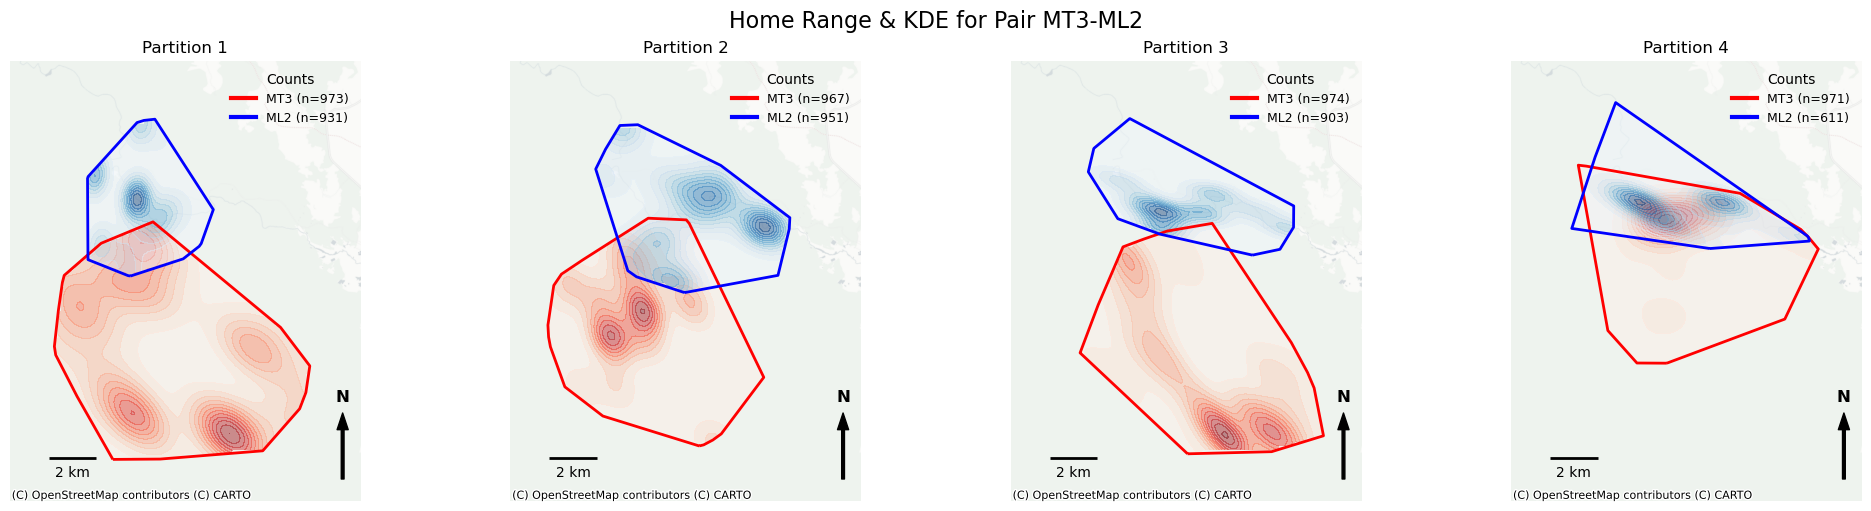

In [35]:
plot_slices_hr_kde_grid(gdf_slices, point_slice, id_pair)

## Figure 3: Heatmap with Index

In [36]:
def harmonize_time_bin_to_labels(
    s: pd.Series,
    bin_labels: list,
    time_bins: list
) -> pd.Categorical:
    """
    Map a time_bin series to your string labels robustly.
    - Normalizes dashes (EN dash → hyphen), trims spaces.
    - If strings already match labels (after normalization), keeps them.
    - Otherwise, expects numeric minutes and bins using `time_bins`.
    """
    s = pd.Series(s)

    # normalize text (dash & spaces)
    s_str = (
        s.astype(str)
         .str.replace("–", "-", regex=False)   # EN dash -> hyphen
         .str.replace("—", "-", regex=False)   # EM dash -> hyphen (just in case)
         .str.strip()
    )

    # also normalize the incoming label set
    norm_labels = [lbl.replace("–","-").replace("—","-").strip() for lbl in bin_labels]

    # if all already labels, return ordered categorical
    if s_str.isin(norm_labels).all():
        return pd.Categorical(s_str, categories=norm_labels, ordered=True)

    # otherwise treat as numeric minutes and cut into bins
    if time_bins is None:
        raise ValueError("Provide time_bins (edges, in minutes) to map numeric time_bin to labels.")
    mins = pd.to_numeric(s, errors='coerce')
    cats = pd.cut(mins, bins=time_bins, labels=norm_labels, include_lowest=True, right=True)
    return pd.Categorical(cats, categories=norm_labels, ordered=True)


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def summarize_obs_pairs(df_obs_pairs: pd.DataFrame, bin_labels: list,
                        time_bins: list) -> pd.DataFrame:
    """
    Observed paired PPAs per (pair_id, slice, time_bin label).
    paired_ppa = 2 * (#rows), since each row is a paired PPA (two directions).
    """
    df = df_obs_pairs.copy()
    # normalize slice (e.g., 'slice003' -> 3)
    if df['slice'].dtype == object:
        df['slice'] = df['slice'].str.replace(r'^slice', '', regex=True).astype(int) + 1
    # pair_id
    df['pair_id'] = df['p1'].astype(str) + '_' + df['p2'].astype(str)
    df['time_bin'] = harmonize_time_bin_to_labels(df['time_bin'], bin_labels, time_bins)
    
    grp = (df.groupby(['pair_id','slice','time_bin'])
             .size().rename('rows').reset_index())
    grp['paired_ppa'] = 2 * grp['rows']  # two directed PPAs per paired row
    return grp[['pair_id', 'slice', 'time_bin', 'paired_ppa']]

In [38]:
def attach_ppa_to_gdf(gdf_merged: pd.DataFrame,
                      df_obs_pairs: pd.DataFrame,
                      bin_labels: list,
                      time_bins: list) -> pd.DataFrame:
    """
    Returns a FULL grid (pair_id, slice, time_bin) with:
      paired_ppa (0 if none), all_ppa (pair×slice), overlapped_area_km2 (pair×slice), ppa_prop.
    """
    base = gdf_merged.copy()

    # --- summarize paired_ppa from obs_pairs ---
    df_obs_summary = summarize_obs_pairs(df_obs_pairs, bin_labels, time_bins)  # returns per pair×slice×time_bin

    # Get total points per (pair_id, slice) from gdf_merged (sum across individuals)
    pts_pair_slice = (
        base[['pair_id','slice','idcollar','n_points', 'overlapped_area_km2']]
        .drop_duplicates()
        .groupby(['pair_id','slice'], as_index=False)
        .agg(total_points=('n_points','sum'),
             overlapped_area_km2=('overlapped_area_km2','first'))
    )
    pts_pair_slice['all_ppa'] = (pts_pair_slice['total_points'] - 2).clip(lower=0)

    # 3) Join all_ppa into the obs summary (pair–slice)
    df_obs_summary = pts_pair_slice[['pair_id','slice','all_ppa', 'overlapped_area_km2']].merge(
        df_obs_summary,
        on=['pair_id','slice'],
        how='left'
    )
    df_obs_summary['ppa_prop'] = (
        df_obs_summary['paired_ppa'] / df_obs_summary['all_ppa'].replace({0: np.nan})
    )

    return df_obs_summary

In [39]:
gdf_merged.head()

,pair_id,idcollar,slice,start,end,n_points,area_km2,overlapped_area_km2,geometry,time_bin,n_events
0,229032_37821,229032,1,2019-10-13 11:00:00,2019-11-24 03:00:00,973,69.014994,5.104088,"POLYGON ((533988.576 1714071.971, 532532.533 1...",0-1h,0
1,229032_37821,229032,1,2019-10-13 11:00:00,2019-11-24 03:00:00,973,69.014994,5.104088,"POLYGON ((533988.576 1714071.971, 532532.533 1...",1h-1d,1
2,229032_37821,229032,1,2019-10-13 11:00:00,2019-11-24 03:00:00,973,69.014994,5.104088,"POLYGON ((533988.576 1714071.971, 532532.533 1...",1-2d,20
3,229032_37821,229032,1,2019-10-13 11:00:00,2019-11-24 03:00:00,973,69.014994,5.104088,"POLYGON ((533988.576 1714071.971, 532532.533 1...",2-4d,59
4,229032_37821,229032,1,2019-10-13 11:00:00,2019-11-24 03:00:00,973,69.014994,5.104088,"POLYGON ((533988.576 1714071.971, 532532.533 1...",4-8d,86


In [40]:
print(sorted(set(str(x) for x in df_obs_pairs['time_bin'].unique())))
print(bin_labels) 

['0-1h', '1-2d', '16-21d', '1h-1d', '2-4d', '4-8d', '8-16d']
['0-1h', '1h-1d', '1-2d', '2-4d', '4-8d', '8-16d', '16-21d']


In [41]:
df_obs_summary = summarize_obs_pairs(df_obs_pairs, bin_labels, time_bins)
df_obs_summary.head()

,pair_id,slice,time_bin,paired_ppa
0,229032_37821,1,0-1h,0
1,229032_37821,1,1h-1d,6
2,229032_37821,1,1-2d,130
3,229032_37821,1,2-4d,308
4,229032_37821,1,4-8d,686


In [42]:
gdf_enriched = attach_ppa_to_gdf(gdf_merged, df_obs_pairs, bin_labels, time_bins)
gdf_enriched.head(20)

,pair_id,slice,all_ppa,overlapped_area_km2,time_bin,paired_ppa,ppa_prop
0,229032_37821,1,1902,5.104088,0-1h,0,0.000000
1,229032_37821,1,1902,5.104088,1h-1d,6,0.003155
2,229032_37821,1,1902,5.104088,1-2d,130,0.068349
3,229032_37821,1,1902,5.104088,2-4d,308,0.161935
4,229032_37821,1,1902,5.104088,4-8d,686,0.360673
5,229032_37821,1,1902,5.104088,8-16d,586,0.308097
6,229032_37821,1,1902,5.104088,16-21d,514,0.270242
7,229032_37821,2,1916,8.320651,0-1h,34,0.017745
8,229032_37821,2,1916,8.320651,1h-1d,724,0.377871
9,229032_37821,2,1916,8.320651,1-2d,232,0.121086


In [43]:
def compute_indices(df: pd.DataFrame,
                    area_col: str = 'overlapped_area_km2',
                    prop_col: str = 'ppa_prop',
                    opportunity_col: str = 'all_ppa',
                    group_by_pair: bool = True) -> pd.DataFrame:
    """
    Adds:
      - D = (proportion) / area
      - I = (D - D0) / (D + D0)   (D0 global or per pair)
      - PC1_norm from ln(all_ppa+1) and ln(area+1)
    """
    out = df.copy()
    eps = 1e-9

    # --- density from proportion ---
    out['D'] = out[prop_col] / (out[area_col].replace({0: np.nan}))

    # --- baseline D0 (global or per pair) ---
    if group_by_pair and 'pair_id' in out.columns:
        out['D0'] = out.groupby('pair_id')['D'].transform('mean')
    else:
        D0 = out['D'].mean()
        out['D0'] = D0

    # --- normalized index I in [-1,1] ---
    out['I'] = (out['D'] - out['D0']) / (out['D'] + out['D0'] + eps)

    # --- size index: prop + overlap ---
    ln_n = np.log(out[prop_col] + 1.0)
    ln_a = np.log(out[area_col] + 1.0)
    z_n  = (ln_n - ln_n.mean()) / (ln_n.std(ddof=0) + eps)
    z_a  = (ln_a - ln_a.mean()) / (ln_a.std(ddof=0) + eps)
    out['PC1'] = z_n + z_a

    pc1_min, pc1_max = out['PC1'].min(), out['PC1'].max()
    out['PC1_norm'] = np.where(
        pc1_max > pc1_min,
        2 * (out['PC1'] - pc1_min) / (pc1_max - pc1_min) - 1,
        0.0
    )

    return out


In [45]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
from typing import List, Union, Tuple
from matplotlib.colors import LinearSegmentedColormap

def plot_interaction_heatmap(
    df: pd.DataFrame,
    bin_labels: List[str],
    pair_id: Union[str, Tuple[int,int]],
    slice_label: str = 'slice',
    prop_col: str = 'ppa_prop',
    opportunity_col: str = 'all_ppa',
    area_col: str = 'overlapped_area_km2',
    size_range: Tuple[int, int] = (20, 400)
):
    # normalize pair_id
    pid = f"{pair_id[0]}_{pair_id[1]}" if isinstance(pair_id, tuple) else pair_id
    dfp = df[df['pair_id'] == pid].copy()
    if dfp.empty:
        raise ValueError(f"No data for pair {pid}")

    # --- ensure we have the proportion column ---
    if prop_col not in dfp.columns:
        if {"paired_ppa", "all_ppa"}.issubset(dfp.columns):
            dfp[prop_col] = (dfp["paired_ppa"] + 0.5) / (dfp["all_ppa"] + 1.0)
        else:
            raise ValueError(
                f"Missing '{prop_col}' and also missing ['paired_ppa','all_ppa'] to derive it."
            )

    # --- compute I and PC1_norm if missing ---
    if ("I" not in dfp.columns) or ("PC1_norm" not in dfp.columns):
        dfp = compute_indices(
            dfp,
            area_col=area_col,
            prop_col=prop_col,
            opportunity_col="all_ppa",
            group_by_pair=True,
        )

    # map axes
    idx_map = {lbl: i for i, lbl in enumerate(bin_labels)}
    dfp['time_idx']  = dfp['time_bin'].map(idx_map)
    dfp['slice_idx'] = dfp[slice_label].astype(int)

    # scale sizes
    norm     = (dfp['PC1_norm'] + 1) / 2
    p = dfp['PC1_norm'].abs()
    cv = p.std() / (p.mean() + 1e-6)
    size_exp = 1 + cv
    norm_exp = norm ** size_exp
    min_s, max_s = size_range
    dfp['size'] = min_s + norm_exp * (max_s - min_s)

    # Define Green–Neutral–Purple colormap (avoidance → neutral → encounter)
    green_purple_cmap = LinearSegmentedColormap.from_list(
        "GreenPurple",
        ["#1b7939", "#ECF3F6", "#742881"]  # green (avoidance) → neutral → brown (encounter)
    )

    # Map IDs to labels
    id1, id2 = pair_id
    label1 = idcollar_mapping.get(str(id1), str(id1))
    label2 = idcollar_mapping.get(str(id2), str(id2))

    # 1) Create a figure whose axes take only 0–0.75 in x
    fig, ax = plt.subplots(
        figsize=(len(bin_labels)*1.0, dfp['slice_idx'].nunique()*0.6),
        constrained_layout=False,
        gridspec_kw={'left':0.1, 'right':0.75}
    )
    
    # 2) Draw the scatter on ax
    sc = ax.scatter(
        dfp['time_idx'], dfp['slice_idx'],
        s=dfp['size'], c=dfp['I'],
        cmap=green_purple_cmap, vmin=-1, vmax=1,
        edgecolor='k'
    )
    
    # 3) Axis formatting
    ax.set_xticks(list(idx_map.values()))
    ax.set_xticklabels(bin_labels, rotation=45, ha='right')
    ax.set_yticks(sorted(dfp['slice_idx'].unique()))
    ax.set_yticklabels(sorted(dfp['slice_idx'].unique()))
    ax.set_xlabel('Time Bin')
    ax.set_ylabel('Partition')
    ax.set_ylim(0.5, dfp['slice_idx'].max()+0.5)
    ax.set_title(f'Interaction Heatmap for Pair {label1}-{label2}', fontsize=16)
    
    # 4) Put the colorbar in the right margin
    cbar_ax = fig.add_axes([0.78, 0.55, 0.02, 0.35])  # [left, bottom, width, height]
    cbar = fig.colorbar(sc, cax=cbar_ax, orientation='vertical')
    # cbar.set_label('I (Normalized \n Interaction Density)', fontsize=9)
    cbar.set_ticks([-1, 1])
    cbar.set_ticklabels(['Avoidance', 'Colocation'])
    cbar.ax.tick_params(labelsize=9)
    cbar.outline.set_linewidth(0.6)
    
    # 5) Build dummy artists for the two legends
    # encounter_color = green_brown_cmap(1.0)  # Brown (encounter)
    # avoidance_color = green_brown_cmap(0.0)  # Green (avoidance)
    # neutral_color   = green_brown_cmap(0.5)  # Neutral

    # color_elements = [
    #     Line2D([0],[0], marker='o', color='w', 
    #            markerfacecolor=encounter_color, markersize=10, label='Encounter'),
    #     Line2D([0],[0], marker='o', color='w', 
    #            markerfacecolor=avoidance_color, markersize=10, label='Avoidance'),
    #     Line2D([0],[0], marker='o', color='w', 
    #            markerfacecolor=neutral_color, markersize=10, label='Neutral')
    # ]
    size_elements = [
        Line2D([0],[0], marker='o', color='white', linestyle='-', markeredgecolor='k',
               markersize=np.sqrt(size_range[0]), label='Weak (Low–Low)'),
        Line2D([0],[0], marker='o', color='white', linestyle='-', markeredgecolor='k',
               markersize=np.sqrt(size_range[1]), label='Strong (High–High)')
    ]
    
    # # 6) Place the color‐type legend
    # fig.legend(
    #     handles=color_elements,
    #     title="Interaction Type",
    #     loc='upper right',
    #     bbox_to_anchor=(0.9, 0.45),
    #     frameon=False
    # )
    
    # 7) Place the size‐strength legend
    fig.legend(
        handles=size_elements,
        title="Association Strength",
        loc='upper right',
        bbox_to_anchor=(1.03, 0.45),
        frameon=False
    )
    
    # plt.savefig(f"../../figure/{pair_id[0]}_{pair_id[1]}_Interaction_Heatmap.jpg", dpi=500, bbox_inches='tight')
    plt.savefig(f"../../figure/{pair_id[0]}_{pair_id[1]}_Interaction_Heatmap_full.jpg", dpi=500, bbox_inches='tight')
    plt.show()

In [46]:
gdf_enriched = attach_ppa_to_gdf(gdf_merged, df_obs_pairs, bin_labels, time_bins)
gdf_idx = compute_indices(gdf_enriched,
        area_col='overlapped_area_km2',
        prop_col='ppa_prop',
        opportunity_col='all_ppa',
        group_by_pair=True)

In [47]:
gdf_idx.head(60)

,pair_id,slice,all_ppa,overlapped_area_km2,time_bin,paired_ppa,ppa_prop,D,D0,I,PC1,PC1_norm
0,229032_37821,1,1902,5.104088,0-1h,0,0.000000,0.000000,0.062727,-1.000000,-1.102147,-0.616158
1,229032_37821,1,1902,5.104088,1h-1d,6,0.003155,0.000618,0.062727,-0.980486,-1.093631,-0.613504
2,229032_37821,1,1902,5.104088,1-2d,130,0.068349,0.013391,0.062727,-0.648151,-0.923392,-0.560447
3,229032_37821,1,1902,5.104088,2-4d,308,0.161935,0.031726,0.062727,-0.328210,-0.696355,-0.489689
4,229032_37821,1,1902,5.104088,4-8d,686,0.360673,0.070664,0.062727,0.059498,-0.269458,-0.356643
5,229032_37821,1,1902,5.104088,8-16d,586,0.308097,0.060363,0.062727,-0.019208,-0.376001,-0.389848
6,229032_37821,1,1902,5.104088,16-21d,514,0.270242,0.052946,0.062727,-0.084556,-0.455398,-0.414593
7,229032_37821,2,1916,8.320651,0-1h,34,0.017745,0.002133,0.062727,-0.934237,-0.501209,-0.428870
8,229032_37821,2,1916,8.320651,1h-1d,724,0.377871,0.045414,0.062727,-0.160102,0.317881,-0.173593
9,229032_37821,2,1916,8.320651,1-2d,232,0.121086,0.014552,0.062727,-0.623382,-0.239738,-0.347380


In [48]:
# gdf_idx.to_csv('../../data/131343_37823_gdf_idx.csv')

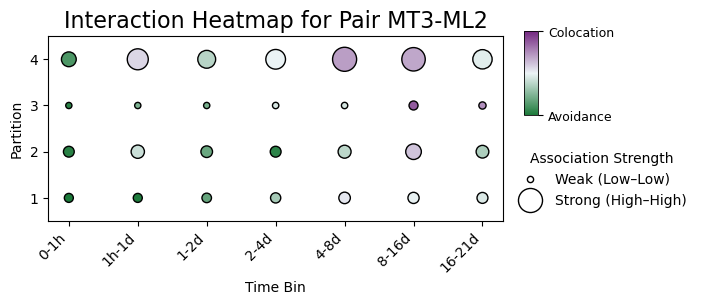

In [49]:
plot_interaction_heatmap(gdf_idx, bin_labels, id_pair, size_range=(20,300))

## Figure 4: Home Range & Heatmap

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# ---- pretty ID helper (uses your mapping) ----
def _nice_label(animal_id: int) -> str:
    return idcollar_mapping.get(str(animal_id), str(animal_id))

# ---- palette + circle sizing ----
def _green_purple_cmap():
    return LinearSegmentedColormap.from_list("GreenPurple", ["#1b7939", "#ECF3F6", "#742881"])

def _circle_sizes(pc1_norm: pd.Series, size_range=(50, 260)) -> np.ndarray:
    # map PC1_norm [-1,1] -> [0,1] -> size range
    v = (pd.Series(pc1_norm).fillna(-1).clip(-1,1) + 1.0) / 2.0
    return size_range[0] + v.values * (size_range[1] - size_range[0])

def _slice_bin_row(gdf_idx: pd.DataFrame, pair: str, sl: int, bin_labels: list) -> pd.DataFrame:
    d = gdf_idx[(gdf_idx["pair_id"] == pair) & (gdf_idx["slice"] == sl)][["time_bin","I","PC1_norm"]].copy()
    d["time_bin"] = d["time_bin"].astype(str).str.replace("–","-").str.replace("—","-").str.strip()
    base = pd.DataFrame({"time_bin": bin_labels})
    return base.merge(d, on="time_bin", how="left")

In [77]:
def plot_slices_hr_kde_grid_split(
    boundary_gdf: gpd.GeoDataFrame,
    point_gdf: gpd.GeoDataFrame,
    gdf_idx: pd.DataFrame,             # needs: pair_id, slice, time_bin, I, PC1_norm
    id_pair: Tuple[int,int],
    bin_labels: list,
    padding_frac: float = 0.05,        # padding around global map extent
    kde_grid_size: int = 100,
    circle_size_range=(50, 260),
    circle_band_height=0.20,           # ↑ more vertical room for circles
    circle_inner_pad: float = 0.04,    # pad inside the union span (fraction of that span)
    fig_scale=(5.2, 5.0),              # per-column, per-row sizing (width, height)
    show_size_legend=True,
    show_colorbar=True,
    save_path=None
):
    """
    Makes a grid. For each partition tile we create two stacked sub-axes:
      (top)  circle strip with time-bin labels, aligned to the MCP union width
      (bottom) home-range + KDE map (now: separate KDEs for each animal)
    """
    id1, id2 = id_pair
    label1, label2 = _nice_label(id1), _nice_label(id2)
    pair = f"{id1}_{id2}"

    # color + colormap per individual
    outline = {
        id1: ("red",  "Reds"),
        id2: ("blue", "Blues"),
    }

    # ------- project / extent -------
    b3857 = boundary_gdf.to_crs(epsg=3857)
    p3857 = point_gdf.to_crs(epsg=3857)

    all_polys = b3857.query("pair_id==@pair")['geometry']
    if all_polys.empty:
        raise ValueError(f"No MCP data for pair {pair}")
    minx, miny, maxx, maxy = all_polys.unary_union.bounds
    pad_x = (maxx - minx) * padding_frac
    pad_y = (maxy - miny) * padding_frac
    # global map limits (same as before)
    xlim0, xlim1 = (minx - pad_x - 1000, maxx + pad_x + 1000)
    ylim0, ylim1 = (miny - pad_y - 1000, maxy + pad_y + 1000)

    slices = sorted(b3857.query("pair_id==@pair")['slice'].unique())
    if not slices:
        raise ValueError(f"No data for pair {pair}")
    n_slices = len(slices)

    # grid geometry (same logic as before)
    if n_slices <= 16:   n_cols = 4
    elif n_slices <= 25: n_cols = 5
    else:                n_cols = 6
    n_rows = int(np.ceil(n_slices / n_cols))

    # --- figure and outer GridSpec ---
    fig_w = fig_scale[0] * n_cols
    fig_h = fig_scale[1] * n_rows * (1 + 0.10)  # a bit taller to accommodate circle bands
    fig = plt.figure(figsize=(fig_w, fig_h))
    gs_outer = GridSpec(nrows=n_rows, ncols=n_cols, figure=fig,
                        left=0.01, right=0.9, top=0.98, bottom=0.02,
                        wspace=0.02, hspace=0.2)

    # KDE grid (global, reused for all panels)
    xi, yi = np.mgrid[xlim0:xlim1:kde_grid_size*1j, ylim0:ylim1:kde_grid_size*1j]
    coords = np.vstack([xi.ravel(), yi.ravel()])

    # aesthetics for circles
    cmap = _green_purple_cmap()
    normI = Normalize(-1, 1)

    # --- loop tiles ---
    for idx, sl in enumerate(slices):
        r = idx // n_cols
        c = idx % n_cols

        # make a 2-row subgrid inside this tile: [circle row, map row]
        gs_tile = GridSpecFromSubplotSpec(
            2, 1, subplot_spec=gs_outer[r, c],
            height_ratios=[circle_band_height, 1 - circle_band_height],
            hspace=0.03
        )

        # ----- BOTTOM: map -----
        axM = fig.add_subplot(gs_tile[1, 0])
        b = b3857.query("pair_id==@pair and slice==@sl")
        p = p3857.query("pair_id==@pair and slice==@sl")

        if b.empty:
            axM.set_visible(False)
        else:
            row1 = b[b["idcollar"] == id1]
            row2 = b[b["idcollar"] == id2]
            poly1 = row1.geometry.values[0] if not row1.empty else None
            poly2 = row2.geometry.values[0] if not row2.empty else None

            # union still used later for circle alignment
            if   poly1 is not None and poly2 is not None: union_poly = poly1.union(poly2)
            elif poly1 is not None:                       union_poly = poly1
            elif poly2 is not None:                       union_poly = poly2
            else:                                         union_poly = None

            axM.set_facecolor('#f0f0f0')
            axM.set_xlim(xlim0, xlim1)
            axM.set_ylim(ylim0, ylim1)
            axM.set_aspect('equal', adjustable='box')
            try:
                ctx.add_basemap(axM, source=ctx.providers.CartoDB.Positron)
            except Exception:
                pass

            # --- NEW: separate KDE per animal, clipped to its own MCP ---
            n1 = len(p[p["idcollar"] == id1])
            n2 = len(p[p["idcollar"] == id2])

            polys = {id1: poly1, id2: poly2}
            for this_id in [id1, id2]:
                pts = p[p["idcollar"] == this_id]
                if len(pts) < 5:
                    continue  # not enough points for smooth KDE

                kde = gaussian_kde(
                    np.vstack([pts.geometry.x.values, pts.geometry.y.values])
                )
                zi = kde(coords).reshape(xi.shape)

                poly = polys[this_id]
                if poly is not None and not poly.is_empty:
                    mask = np.array(
                        [poly.contains(Point(x, y)) for x, y in zip(coords[0], coords[1])]
                    ).reshape(xi.shape)
                    zi = np.ma.masked_where(~mask, zi)

                cmap_kde = outline[this_id][1]  # 'Reds' or 'Blues'
                axM.contourf(
                    xi, yi, zi, levels=12,
                    cmap=cmap_kde, alpha=0.45, zorder=1
                )

            # outlines + legend with pretty IDs
            if poly1 is not None:
                row1.plot(
                    ax=axM, facecolor="none",
                    edgecolor=outline[id1][0], linewidth=2, zorder=3
                )
            if poly2 is not None:
                row2.plot(
                    ax=axM, facecolor="none",
                    edgecolor=outline[id2][0], linewidth=2, zorder=3
                )

            axM.legend(
                handles=[
                    Line2D([0],[0], color=outline[id1][0], lw=3, label=f"{label1} (n={n1})"),
                    Line2D([0],[0], color=outline[id2][0], lw=3, label=f"{label2} (n={n2})"),
                ],
                title="Counts", loc="upper right",
                fontsize=12, title_fontsize=13, frameon=False
            )

            # 2 km scale + north
            x0 = xlim0 + 0.05*(xlim1 - xlim0)
            y0 = ylim0 + 0.05*(ylim1 - ylim0)
            x1 = x0 + 2_000
            axM.hlines(
                y=y0 + 0.1*(ylim1 - ylim0),
                xmin=x0, xmax=x1,
                colors="k", linewidth=2
            )
            axM.text(
                (x0+x1)/2, y0 + 0.14*(ylim1 - ylim0), "2 km",
                ha="center", va="top", fontsize=10, color="k"
            )
            axM.annotate(
                '', xy=(0.95,0.2), xycoords='axes fraction',
                xytext=(0.95,0.05), textcoords='axes fraction',
                arrowprops=dict(facecolor='k', width=2, headwidth=8)
            )
            axM.text(
                0.95, 0.22, 'N', transform=axM.transAxes,
                ha='center', va='bottom', fontsize=12,
                fontweight='bold'
            )
            axM.set_axis_off()

        # ----- TOP: circles (unchanged) -----
        axC = fig.add_subplot(gs_tile[0, 0])
        axC.set_xlim(0, 1); axC.set_ylim(0, 1)
        axC.set_xticks([]); axC.set_yticks([])
        for sp in axC.spines.values():
            sp.set_visible(False)

        # per-slice union bounds for alignment (fallback to global if missing)
        ux0, ux1 = None, None
        if not b.empty:
            try:
                union_for_span = union_poly if union_poly is not None else b.unary_union
                if (union_for_span is not None) and (not union_for_span.is_empty):
                    ux0, uy0, ux1, uy1 = union_for_span.bounds
            except Exception:
                pass
        if (ux0 is None) or (ux1 is None) or not np.isfinite([ux0, ux1]).all():
            ux0, ux1 = (minx, maxx)  # fallback to global pair span (un-padded)

        total_span = (xlim1 - xlim0)
        start_norm = np.clip((ux0 - xlim0) / total_span, 0.0, 1.0)
        end_norm   = np.clip((ux1 - xlim0) / total_span, 0.0, 1.0)

        span_norm  = max(end_norm - start_norm, 1e-6)
        start_norm += circle_inner_pad * span_norm
        end_norm   -= circle_inner_pad * span_norm
        start_norm, end_norm = float(start_norm), float(end_norm)
        if not (end_norm > start_norm):
            start_norm, end_norm = 0.08, 0.92

        xs = np.linspace(start_norm, end_norm, len(bin_labels))
        ys = np.full(len(bin_labels), 0.62)

        row_df = _slice_bin_row(gdf_idx, pair, sl, bin_labels)
        sizes  = _circle_sizes(row_df["PC1_norm"], size_range=circle_size_range)
        colors = [cmap(normI(v)) if pd.notna(v) else (0,0,0,0) for v in row_df["I"]]
        axC.scatter(xs, ys, s=sizes, c=colors,
                    edgecolors="k", linewidths=0.6, zorder=2)

        for x, lbl in zip(xs, bin_labels):
            axC.text(x, 0.16, lbl, ha="center", va="bottom", fontsize=10)

        axC.text(
            0.01, 0.94, f"Partition {sl}", ha="left", va="top",
            fontsize=12, transform=axC.transAxes,
            bbox=dict(facecolor="white", alpha=0.6, pad=2, edgecolor='none'),
            zorder=5
        )

    # ---- global legends/top matter ----
    if show_colorbar:
        cb_ax = fig.add_axes([0.92, 0.80, 0.012, 0.13])
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=normI); sm.set_array([])
        cbar = plt.colorbar(sm, cax=cb_ax, orientation='vertical')
        cbar.set_ticks([-1, 1]); cbar.set_ticklabels(['Avoidance', 'Colocation'])
        cbar.ax.tick_params(labelsize=12); cbar.outline.set_linewidth(0.6)

    if show_size_legend:
        lg_ax = fig.add_axes([0.91, 0.65, 0.07, 0.08]); lg_ax.axis("off")
        s_min, s_max = circle_size_range
        handles = [
            Line2D([0],[0], marker='o', color='white', markeredgecolor='k',
                   markersize=np.sqrt(s_min), label='Weak'),
            Line2D([0],[0], marker='o', color='white', markeredgecolor='k',
                   markersize=np.sqrt(s_max), label='Strong')
        ]
        lg_ax.legend(handles=handles, title="Association strength", ncol=1,
                     loc="center", frameon=False, fontsize=12, title_fontsize=13)

    fig.canvas.draw()
    if save_path:
        plt.savefig(save_path, dpi=500)
    else:
        out_path = f"../../figure/{id_pair[0]}_{id_pair[1]}_Home_Range_KDE.jpg"
        plt.savefig(out_path, dpi=500)
    plt.show()

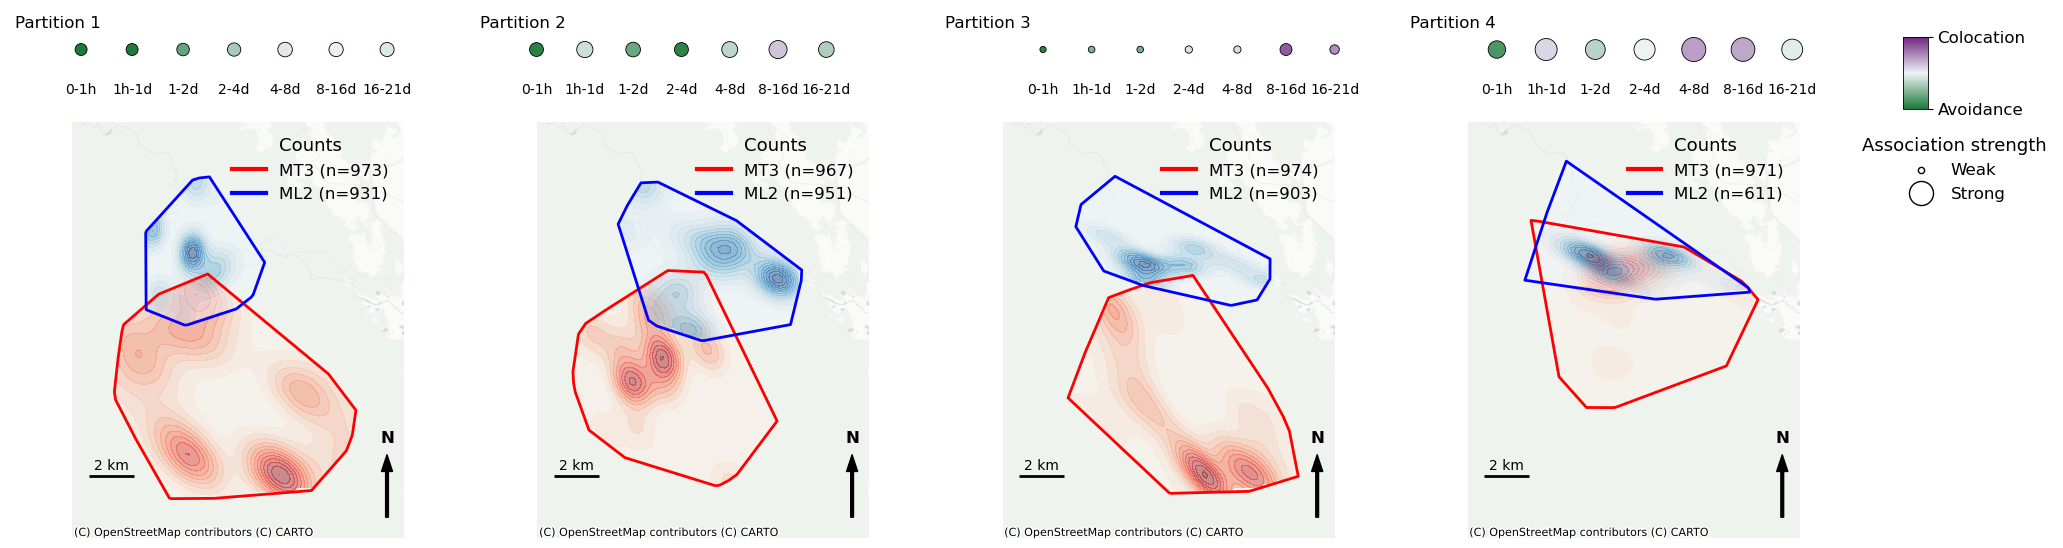

In [52]:
plot_slices_hr_kde_grid_split(
    boundary_gdf=gdf_slices,
    point_gdf=point_slice,
    gdf_idx=gdf_idx,         # contains I and PC1_norm per (pair, slice, time_bin)
    id_pair=id_pair,
    bin_labels=bin_labels,   # ["0-1d","1-2d","2-4d","4-8d","8-16d","16-21d"]
    circle_size_range=(20,300),
    circle_band_height=0.2   # a touch taller if needed
)


#### Parellel processing

---------Pair (131343, 37823)-------------------
sim_events: 5599616 rows | MC kept: 1000 (min=1, max=1000)
sim_pairs: 15166414 rows | MC kept: 1000 (min=1, max=1000)
obs_events: 11411 rows
obs_pairs: 35915 rows
   slice time_bin  sim_median  obs_sum  obs_count   p_value  significant
0      1     0-1h  319.116667   1079.0          6  0.028708         True
1      2     0-1h  286.683333    840.0          5  0.048469         True
2      3     0-1h  267.791667    542.0          3  0.154345        False
3      4     0-1h  217.200000    540.0          3  0.085271        False
4      5     0-1h  285.741667    661.0          4  0.096862        False
5      6     0-1h  290.666667    776.0          6  0.068293        False
6      7     0-1h  304.800000    657.0          3  0.146746        False
7      8     0-1h  293.625000    421.0          2  0.307600        False
8      9     0-1h  284.533333    660.0          5  0.109023        False
     slice time_bin           leader  n_sim  n_obs        

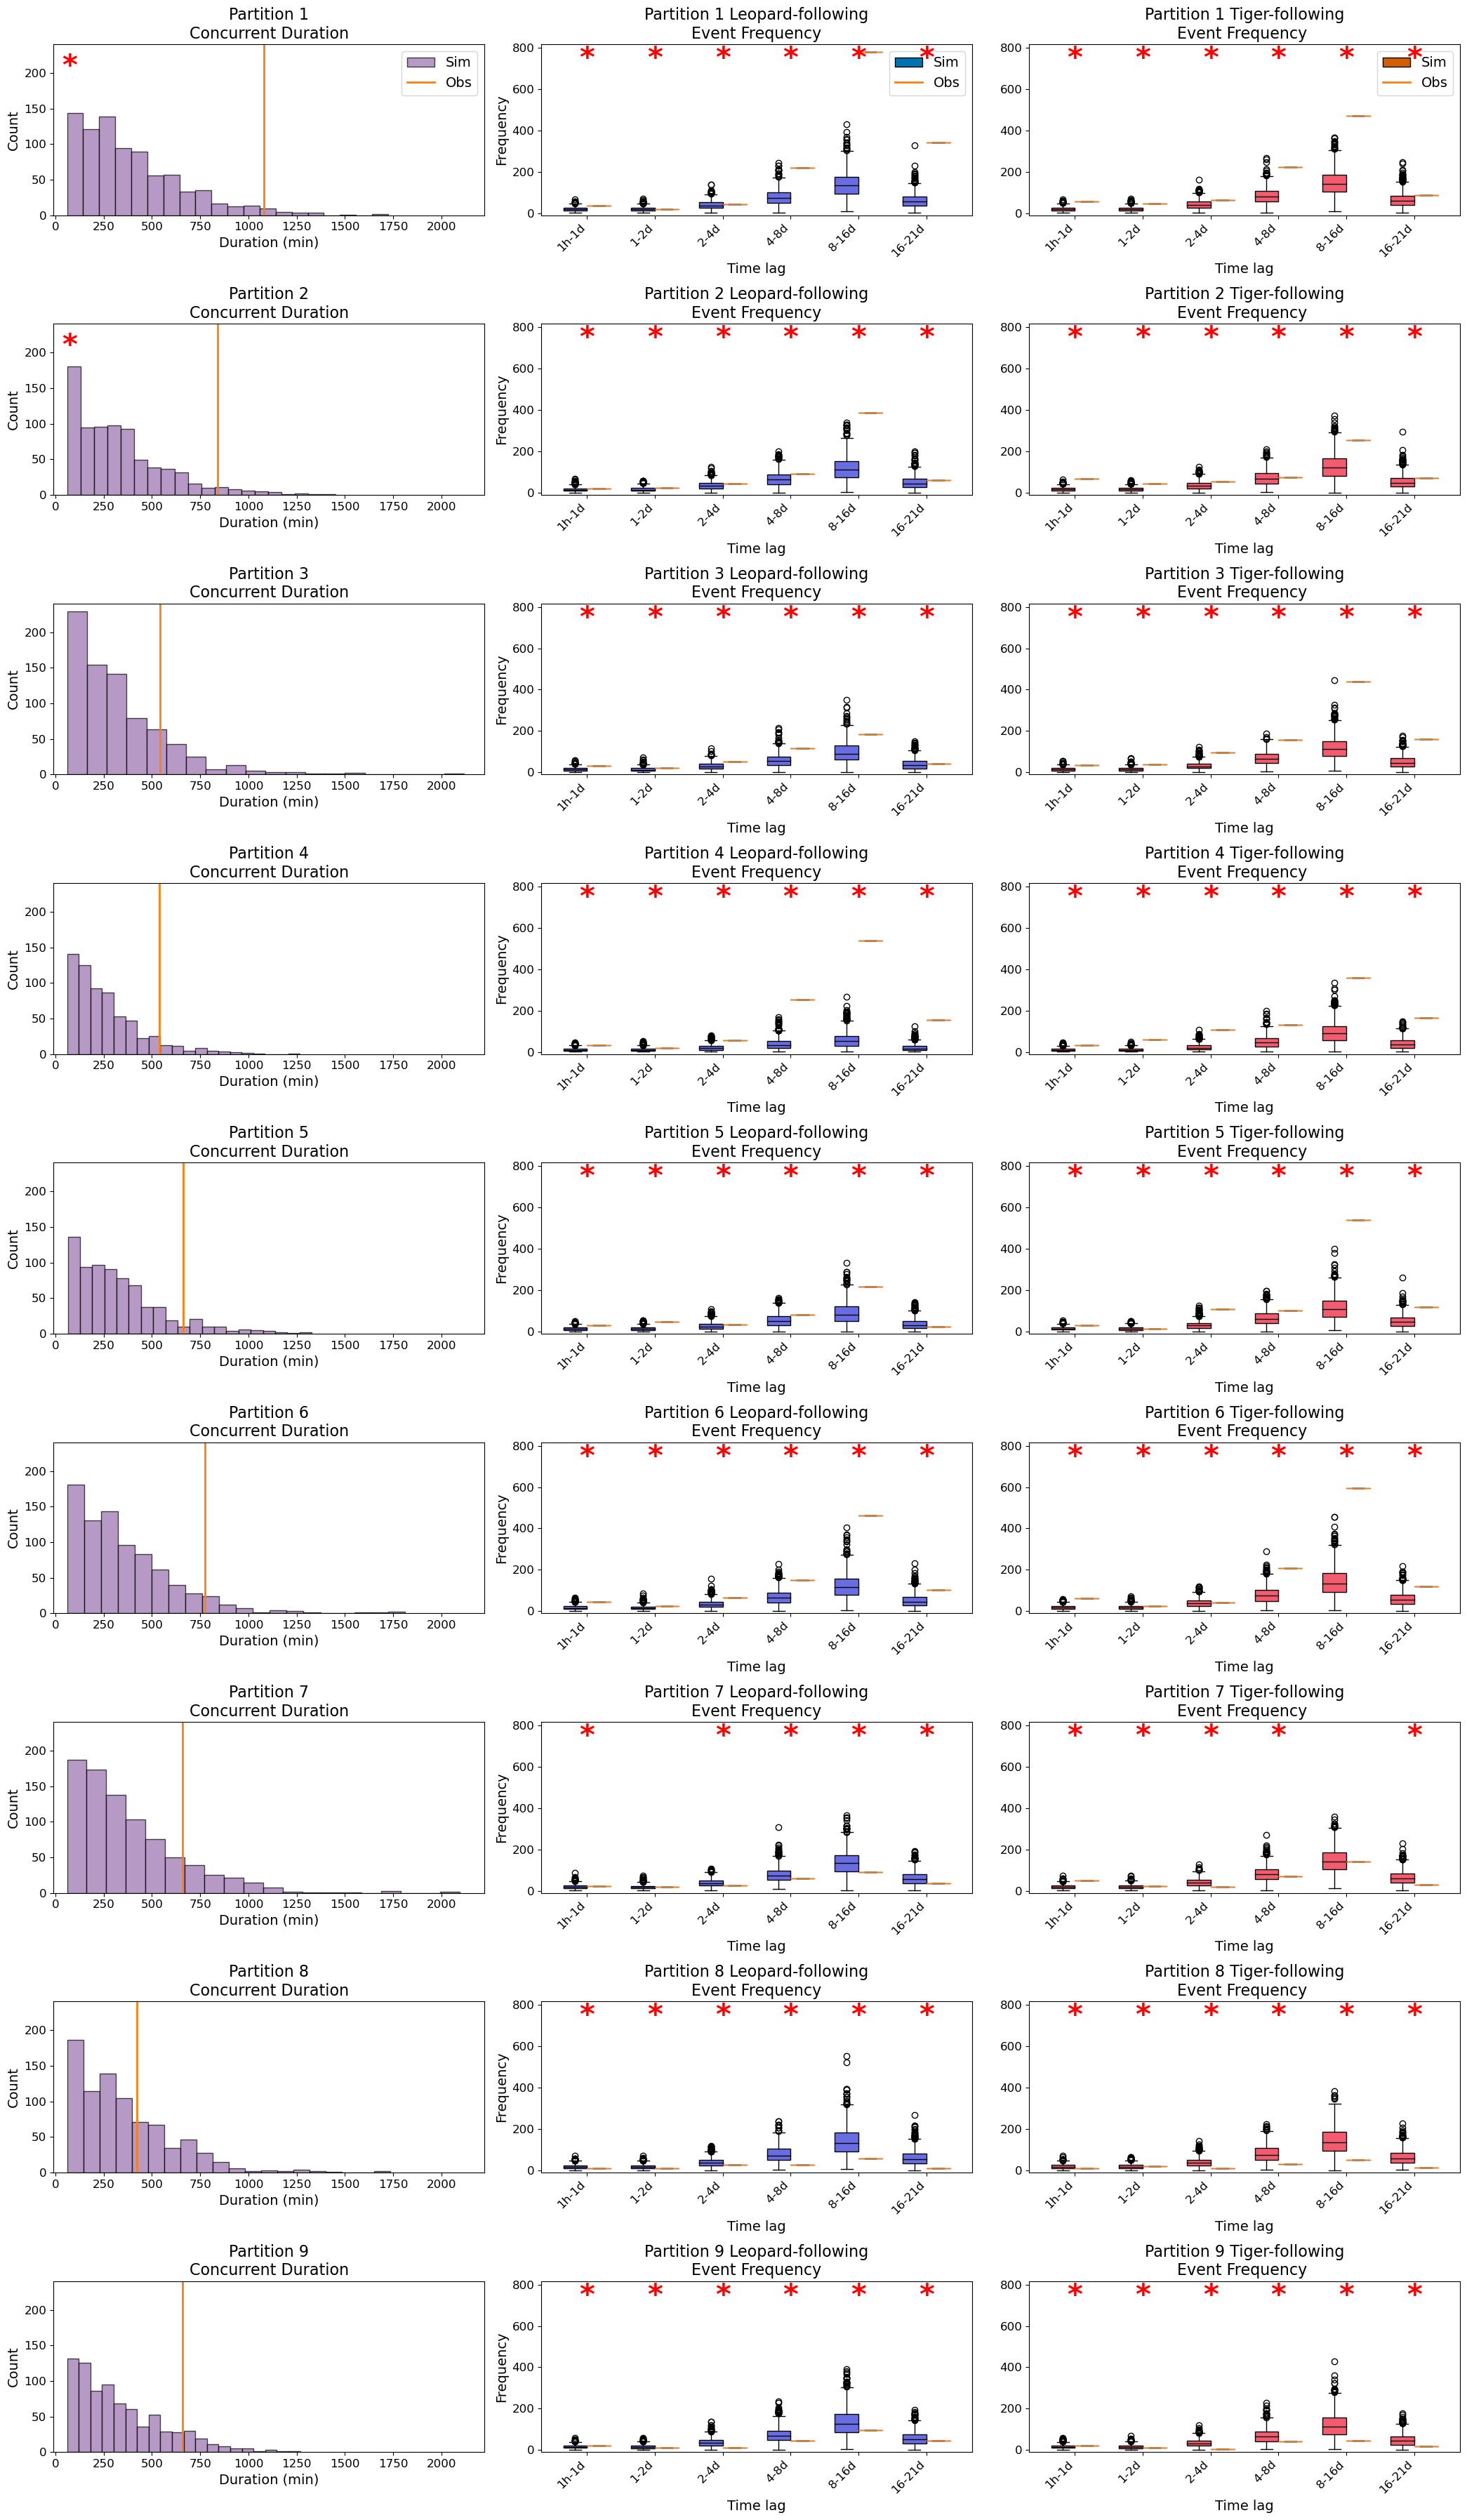

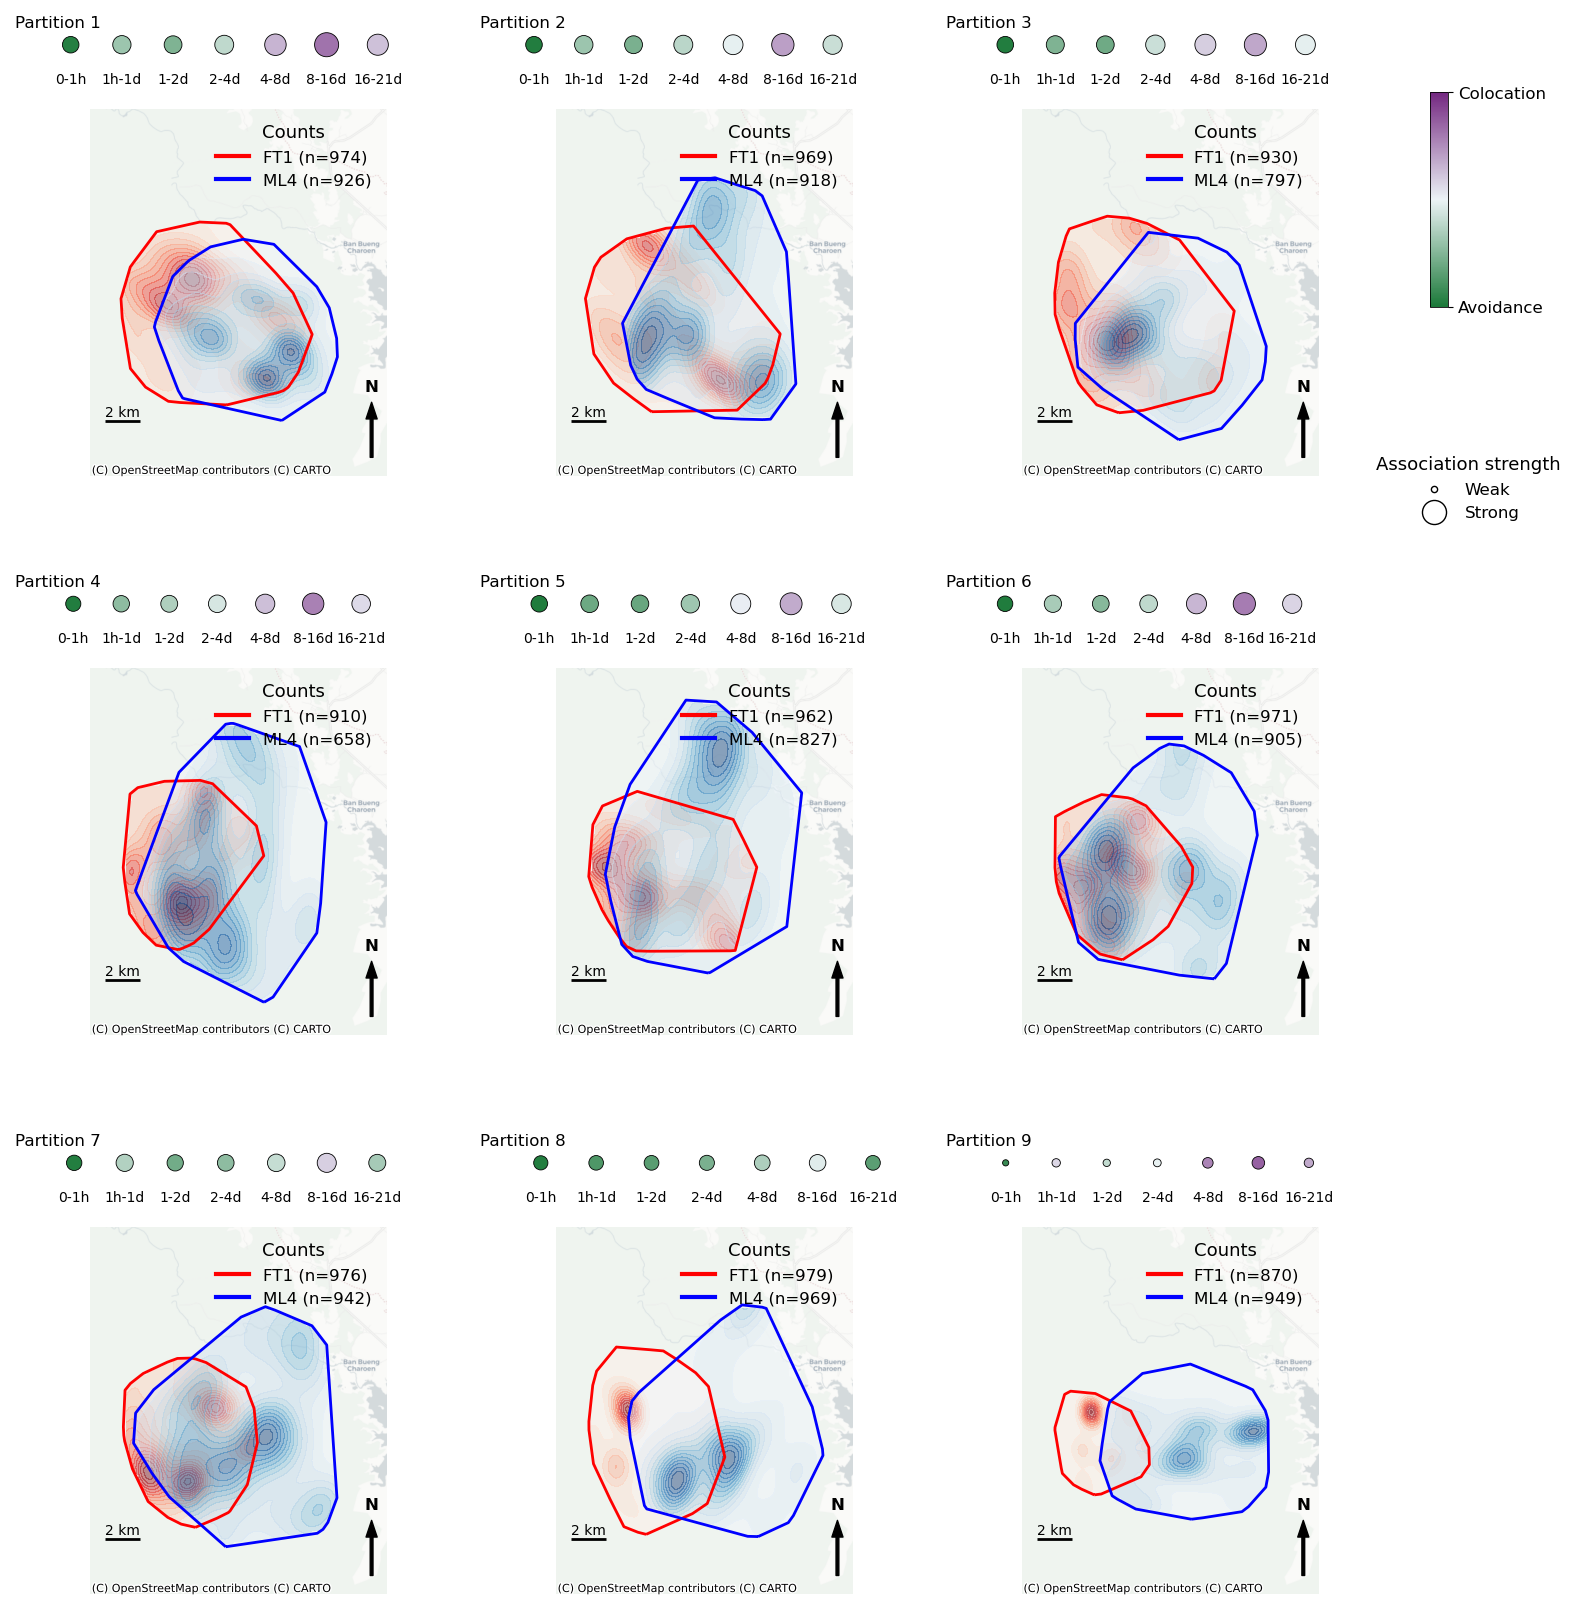

In [76]:
import warnings
warnings.filterwarnings('ignore')

# id_pairs = [(229041, 31898), (229041, 31899),
#             (131343, 31898), (131343, 31899), (131343, 37822), (229011, 31898), 
#             (229012, 31898), (229012, 37821), (229012, 37823), (229022, 31898), (229022, 31899),
#             (229022, 37822), (229022, 37823), (229032, 31898), (229032, 37822), (229032, 37823)]

# id_pairs = [(131343, 37821), (229032, 37821)]
id_pairs = [(131343, 37823)]

idcollar_mapping = {
    '131343': 'FT1',
    '229011': 'FT2',
    '229041': 'FT3',
    '229012': 'MT1',
    '229022': 'MT2',
    '229032': 'MT3',
    '31899': 'FL',
    '31898': 'ML1',
    '37821': 'ML2',
    '37822': 'ML3',
    '37823': 'ML4'
}


# time_bins   = [0, 60, 180, 360, 720, 1440, 2880, 5760, 11520, 23040, 30240]
# bin_labels = ["0-1h","1-3h","3-6h","6-12h","12-24h","1-2d","2-4d","4-8d","8-16d", "16-21d"]
bin_labels = ["0-1h", "1h-1d", "1-2d","2-4d","4-8d","8-16d", "16-21d"]
time_bins   = [0, 60, 1440, 2880, 5760, 11520, 23040, 30240]

# Tracking data path
file_path = "../../data/tiger_leopard_env_tg.csv"
adjusted_dir  = "../../data"


for id_pair in id_pairs:
    print(f"---------Pair {id_pair}-------------------")

    id1, id2 = id_pair
    base_dir1 = Path(f"../../simulated_trajectory/CRW_slice_RT_MC50/by_slice_{id1}_{id2}_reverse_time")            
    # base_dir2 = Path(f"../../simulated_trajectory/CRW_slice_RT_MC2000/by_slice_{id1}_{id2}_reverse_time")   

    # normalize_mc_padding_inplace(base_dir1, id_pair, target_width=3, dry_run=False)
    # normalize_mc_padding_inplace(base_dir2, id_pair, target_width=3, dry_run=False)
    
    # copy_and_renumber_mc_files(
    #     id_pair = id_pair,
    #     base_dir1 = base_dir1,
    #     base_dir2 = base_dir2,
    #     offset=50,          # base_dir1 has MC001..MC050; dir2 MC001..MC850 → MC051..MC900
    #     max_mc_dir2=850,    # only take first 850 from dir2
    #     dry_run=False       # set True first if you want to preview actions
    # )
    
    # Load results
    results = summarize_interaction_results(id_pair, bin_labels = bin_labels, max_mc = 1000)
    df_sim_events = results["sim_events"]
    df_sim_pairs = results["sim_pairs"]
    df_obs_events = results["obs_events"]
    df_obs_pairs = results["obs_pairs"]
    slices_all = sorted(df_sim_events['slice'].unique())
    # slices_first4 = slices_all[:4]

    # Figure 1
    plot_slicewise_threepanel(
    df_sim_events,
    df_obs_events,
    id_pair,
    bin_labels,
    "0-1h",
    slices_all,
    bins=20,
    figsize_per_row=(7,4),
    title_fs=16, label_fs=14, tick_fs=12, star_fs=30, legend_fs=14
)
    
    # Figure 2
    gdf_slices, point_slice = compute_slice_home_ranges_with_points(file_path, id_pairs, adjusted_dir)   
    gdf_merged = integrate_event_counts(df_obs_events, gdf_slices, bin_labels)
    # plot_slices_hr_kde_grid(gdf_slices, point_slice, id_pair)
    
    # gdf_slices_plot  = gdf_slices[gdf_slices["slice"].isin(slices_first4)].copy()
    # point_slice_plot = point_slice[point_slice["slice"].isin(slices_first4)].copy()
    # plot_slices_hr_kde_grid(gdf_slices_plot, point_slice_plot, id_pair)

    # # # Figure 3
    gdf_enriched = attach_ppa_to_gdf(gdf_merged, df_obs_pairs, bin_labels, time_bins)    
    gdf_idx = compute_indices(gdf_enriched,
            area_col='overlapped_area_km2',
            prop_col='ppa_prop',
            opportunity_col='all_ppa',
            group_by_pair=True)
    # plot_interaction_heatmap(gdf_idx, bin_labels, id_pair, size_range=(20, 300))


    # gdf_idx_plot = gdf_idx[gdf_idx["slice"].isin(slices_first4)].copy()
    # if "time_bin" in gdf_idx_plot.columns:
    #     gdf_idx_plot["time_bin"] = pd.Categorical(gdf_idx_plot["time_bin"], categories=bin_labels, ordered=True)
    # plot_interaction_heatmap(gdf_idx_plot, bin_labels, id_pair, size_range=(20, 300))

    # # # Figure 4
    plot_slices_hr_kde_grid_split(
    boundary_gdf=gdf_slices,
    point_gdf=point_slice,
    gdf_idx=gdf_idx,         # contains I and PC1_norm per (pair, slice, time_bin)
    id_pair=id_pair,
    bin_labels=bin_labels,   # ["0-1d","1-2d","2-4d","4-8d","8-16d","16-21d"]
    circle_size_range=(20,300),
    circle_band_height=0.2   # a touch taller if needed
)

    

---------Pair (131343, 37823)-------------------
sim_events: 5599616 rows | MC kept: 1000 (min=1, max=1000)
sim_pairs: 15166414 rows | MC kept: 1000 (min=1, max=1000)
obs_events: 11411 rows
obs_pairs: 35915 rows
Extracted tracking data saved to ../../data\adjusted_timeline_131343_37823.csv


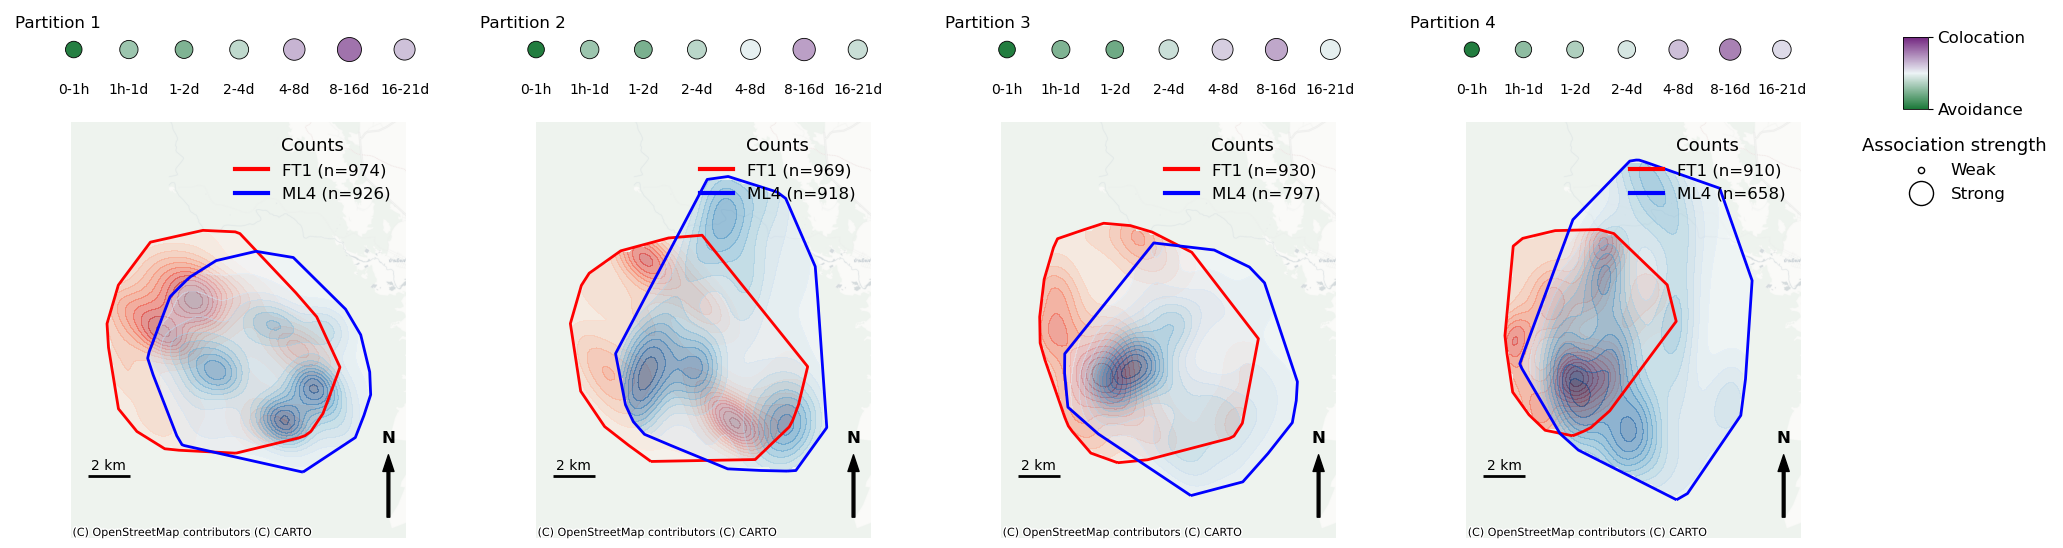

In [54]:
import warnings
warnings.filterwarnings('ignore')

# id_pairs = [(229041, 31898), (229041, 31899),
#             (131343, 31898), (131343, 31899), (131343, 37822), (229011, 31898), 
#             (229012, 31898), (229012, 37821), (229012, 37823), (229022, 31898), (229022, 31899),
#             (229022, 37822), (229022, 37823), (229032, 31898), (229032, 37822), (229032, 37823)]

# id_pairs = [(131343, 37821), (229032, 37821)]
id_pairs = [(131343, 37823)]

idcollar_mapping = {
    '131343': 'FT1',
    '229011': 'FT2',
    '229041': 'FT3',
    '229012': 'MT1',
    '229022': 'MT2',
    '229032': 'MT3',
    '31899': 'FL',
    '31898': 'ML1',
    '37821': 'ML2',
    '37822': 'ML3',
    '37823': 'ML4'
}


# time_bins   = [0, 60, 180, 360, 720, 1440, 2880, 5760, 11520, 23040, 30240]
# bin_labels = ["0-1h","1-3h","3-6h","6-12h","12-24h","1-2d","2-4d","4-8d","8-16d", "16-21d"]
bin_labels = ["0-1h", "1h-1d", "1-2d","2-4d","4-8d","8-16d", "16-21d"]
time_bins   = [0, 60, 1440, 2880, 5760, 11520, 23040, 30240]

# Tracking data path
file_path = "../../data/tiger_leopard_env_tg.csv"
adjusted_dir  = "../../data"


for id_pair in id_pairs:
    print(f"---------Pair {id_pair}-------------------")

    id1, id2 = id_pair
    base_dir1 = Path(f"../../simulated_trajectory/CRW_slice_RT_MC50/by_slice_{id1}_{id2}_reverse_time")            
    # base_dir2 = Path(f"../../simulated_trajectory/CRW_slice_RT_MC2000/by_slice_{id1}_{id2}_reverse_time")   

    # normalize_mc_padding_inplace(base_dir1, id_pair, target_width=3, dry_run=False)
    # normalize_mc_padding_inplace(base_dir2, id_pair, target_width=3, dry_run=False)
    
    # copy_and_renumber_mc_files(
    #     id_pair = id_pair,
    #     base_dir1 = base_dir1,
    #     base_dir2 = base_dir2,
    #     offset=50,          # base_dir1 has MC001..MC050; dir2 MC001..MC850 → MC051..MC900
    #     max_mc_dir2=850,    # only take first 850 from dir2
    #     dry_run=False       # set True first if you want to preview actions
    # )
    
    # Load results
    results = summarize_interaction_results(id_pair, bin_labels = bin_labels, max_mc = 1000)
    df_sim_events = results["sim_events"]
    df_sim_pairs = results["sim_pairs"]
    df_obs_events = results["obs_events"]
    df_obs_pairs = results["obs_pairs"]
    slices_all = sorted(df_sim_events['slice'].unique())
    slices_first4 = slices_all[:4]

#     # Figure 1
#     plot_slicewise_threepanel(
#     df_sim_events,
#     df_obs_events,
#     id_pair,
#     bin_labels,
#     "0-1h",
#     slices_first4,
#     bins=20,
#     figsize_per_row=(7,4),
#     title_fs=16, label_fs=14, tick_fs=12, star_fs=30, legend_fs=14
# )
    
    # Figure 2
    gdf_slices, point_slice = compute_slice_home_ranges_with_points(file_path, id_pairs, adjusted_dir)   
    gdf_merged = integrate_event_counts(df_obs_events, gdf_slices, bin_labels)
    # plot_slices_hr_kde_grid(gdf_slices, point_slice, id_pair)
    
    gdf_slices_plot  = gdf_slices[gdf_slices["slice"].isin(slices_first4)].copy()
    point_slice_plot = point_slice[point_slice["slice"].isin(slices_first4)].copy()
    # plot_slices_hr_kde_grid(gdf_slices_plot, point_slice_plot, id_pair)

    # # # Figure 3
    gdf_enriched = attach_ppa_to_gdf(gdf_merged, df_obs_pairs, bin_labels, time_bins)    
    gdf_idx = compute_indices(gdf_enriched,
            area_col='overlapped_area_km2',
            prop_col='ppa_prop',
            opportunity_col='all_ppa',
            group_by_pair=True)
    # plot_interaction_heatmap(gdf_idx, bin_labels, id_pair, size_range=(20, 300))


    gdf_idx_plot = gdf_idx[gdf_idx["slice"].isin(slices_first4)].copy()
    if "time_bin" in gdf_idx_plot.columns:
        gdf_idx_plot["time_bin"] = pd.Categorical(gdf_idx_plot["time_bin"], categories=bin_labels, ordered=True)
    # plot_interaction_heatmap(gdf_idx_plot, bin_labels, id_pair, size_range=(20, 300))

    # # # Figure 4
    plot_slices_hr_kde_grid_split(
    boundary_gdf=gdf_slices_plot,
    point_gdf=point_slice_plot,
    gdf_idx=gdf_idx_plot,         # contains I and PC1_norm per (pair, slice, time_bin)
    id_pair=id_pair,
    bin_labels=bin_labels,   # ["0-1d","1-2d","2-4d","4-8d","8-16d","16-21d"]
    circle_size_range=(20,300),
    circle_band_height=0.2   # a touch taller if needed
)
    

## Figure 5: Overall Description

In [65]:
summary_data = [
    ["MT3-ML2","High-conflict dynamics", "Leopard-following","Tiger-following","Tiger-following","Bidirectional following",None,None,None,None,None,None,None,None],
    ["FT1-FL","Home range shift competition", "No overlap","Leopard-following","No overlap","No overlap","No overlap","No overlap","No overlap","No overlap",None,None,None,None],
    ["FT1-ML2","Home range shift competition", "Leopard-following","Tiger-following","Avoidance","Avoidance",None,None,None,None,None,None,None,None],
    ["FT1-ML3","Home range shift competition", "Leopard-following","Avoidance","No overlap",None,None,None,None,None,None,None,None,None],
    ["MT2-ML3","Home range shift competition", "Leopard-following","Avoidance",None,None,None,None,None,None,None,None,None,None],
    ["FT3-FL","Home range shift competition", "Avoidance","No overlap","No overlap","Tiger-following",None,None,None,None,None,None,None,None],
    ["MT3-ML3","Home range shift competition", "Avoidance","Avoidance","No overlap",None,None,None,None,None,None,None,None,None],
    ["MT3-ML1","Home range shift competition", "Avoidance","Avoidance","Avoidance",None,None,None,None,None,None,None,None,None],
    ["FT2-ML1","Home range shift competition", "Avoidance","Avoidance",None,None,None,None,None,None,None,None,None,None],
    ["MT2-FL","Home range shift competition", "Avoidance","Avoidance",None,None,None,None,None,None,None,None,None,None],
    ["MT2-ML1","Home range shift competition", "Avoidance","Avoidance",None,None,None,None,None,None,None,None,None,None],
    ["FT1-ML1","Stable coexistence", "Leopard-following","Tiger-following","Tiger-following","Avoidance","Avoidance","Leopard-following","Avoidance","Avoidance","Avoidance","Avoidance","Leopard-following","Tiger-following"],
    ["FT1-ML4","Stable coexistence", "Leopard-following","Leopard-following","Tiger-following","Leopard-following","Tiger-following","Tiger-following","Avoidance","Avoidance","Avoidance",None,None,None],
    ["FT3-ML1","Stable coexistence", "Avoidance","Tiger-following","Avoidance","Avoidance","Avoidance","Avoidance","Leopard-following","Tiger-following",None,None,None,None],
    ["MT1-ML4","Stable coexistence", "Avoidance","Tiger-following","Tiger-following","Tiger-following","Leopard-following","Avoidance","Avoidance","Tiger-following",None,None,None,None],
    ["MT2-ML4","Stable coexistence", "Avoidance","Tiger-following","Leopard-following","Leopard-following","Leopard-following","Tiger-following","Leopard-following","Tiger-following","Tiger-following",None,None,None],
    ["MT3-ML4","Stable coexistence", "Leopard-following","Leopard-following","Leopard-following","Tiger-following","Tiger-following","Leopard-following","Leopard-following","Avoidance",None,None,None,None],
]

cols = ["Pair","Type"] + [f"Slice {i}" for i in range(12)]
df_summary = pd.DataFrame(summary_data, columns=cols)

df_summary.head()

,Pair,Type,Slice 0,Slice 1,Slice 2,Slice 3,Slice 4,Slice 5,Slice 6,Slice 7,Slice 8,Slice 9,Slice 10,Slice 11
0,MT3-ML2,High-conflict dynamics,Leopard-following,Tiger-following,Tiger-following,Bidirectional following,None,None,None,None,None,None,None,None
1,FT1-FL,Home range shift competition,No overlap,Leopard-following,No overlap,No overlap,No overlap,No overlap,No overlap,No overlap,None,None,None,None
2,FT1-ML2,Home range shift competition,Leopard-following,Tiger-following,Avoidance,Avoidance,None,None,None,None,None,None,None,None
3,FT1-ML3,Home range shift competition,Leopard-following,Avoidance,No overlap,None,None,None,None,None,None,None,None,None
4,MT2-ML3,Home range shift competition,Leopard-following,Avoidance,None,None,None,None,None,None,None,None,None,None


### Simple classification

In [66]:
def row_to_features(row):
    vals = [row[c] for c in slice_cols]
    vals = [v for v in vals if v is not None and not (isinstance(v, float) and np.isnan(v))]
    n = len(vals) if len(vals)>0 else 1
    feats = {f"prop_{lab}": vals.count(lab)/n for lab in labels}
    feats["n_slices_nonnull"] = n
    # Balance & dominance metrics
    feats["follow_balance"] = feats["prop_Tiger-following"] - feats["prop_Leopard-following"]
    feats["avoidance_dominance"] = feats["prop_Avoidance"] - max(feats["prop_Tiger-following"], feats["prop_Leopard-following"])
    feats["any_chasing"] = 1.0 if ("Bidirectional following" in vals) else 0.0
    return feats

In [67]:
# --- Feature engineering: proportions of slice-level labels by pair ---
slice_cols = [c for c in df_summary.columns if c.startswith("Slice")]
labels = ["Leopard-following","Tiger-following","Avoidance","No overlap","Bidirectional following"]

X = df_summary.apply(row_to_features, axis=1, result_type="expand")
X["Pair"] = df_summary["Pair"]
y = df_summary["Type"]

In [68]:
# Show the engineered feature table (rounded for readability)
display_cols = ["Pair"] + [c for c in X.columns if c!="Pair"]
X_display = X.copy()
for c in display_cols:
    if c!="Pair":
        X_display[c] = X_display[c].astype(float).round(3)

X_display

,prop_Leopard-following,prop_Tiger-following,prop_Avoidance,prop_No overlap,prop_Bidirectional following,n_slices_nonnull,follow_balance,avoidance_dominance,any_chasing,Pair
0,0.250,0.500,0.000,0.000,0.25,4.0,0.250,-0.500,1.0,MT3-ML2
1,0.125,0.000,0.000,0.875,0.00,8.0,-0.125,-0.125,0.0,FT1-FL
2,0.250,0.250,0.500,0.000,0.00,4.0,0.000,0.250,0.0,FT1-ML2
3,0.333,0.000,0.333,0.333,0.00,3.0,-0.333,0.000,0.0,FT1-ML3
4,0.500,0.000,0.500,0.000,0.00,2.0,-0.500,0.000,0.0,MT2-ML3
5,0.000,0.250,0.250,0.500,0.00,4.0,0.250,0.000,0.0,FT3-FL
6,0.000,0.000,0.667,0.333,0.00,3.0,0.000,0.667,0.0,MT3-ML3
7,0.000,0.000,1.000,0.000,0.00,3.0,0.000,1.000,0.0,MT3-ML1
8,0.000,0.000,1.000,0.000,0.00,2.0,0.000,1.000,0.0,FT2-ML1
9,0.000,0.000,1.000,0.000,0.00,2.0,0.000,1.000,0.0,MT2-FL


In [69]:
# --- A very small, simple classifier ---
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegression(max_iter=1000, multi_class="ovr"))
])

loo = LeaveOneOut()
X_mat = X.drop(columns=["Pair"]).values
y_vec = y.values

# Base KDD predictions (LOOCV)
y_pred = cross_val_predict(pipe, X_mat, y_vec, cv=loo)

print("=== Base KDD (no rule) ===")
print(classification_report(y_vec, y_pred, zero_division=0))
print("Accuracy:", accuracy_score(y_vec, y_pred))
print("Labels:", sorted(pd.Series(y_vec).unique()))
print(confusion_matrix(y_vec, y_pred, labels=sorted(pd.Series(y_vec).unique())))

=== Base KDD (no rule) ===
                              precision    recall  f1-score   support

      High-conflict dynamics       0.00      0.00      0.00         1
Home range shift competition       1.00      1.00      1.00        10
          Stable coexistence       0.86      1.00      0.92         6

                    accuracy                           0.94        17
                   macro avg       0.62      0.67      0.64        17
                weighted avg       0.89      0.94      0.91        17

Accuracy: 0.9411764705882353
Labels: ['High-conflict dynamics', 'Home range shift competition', 'Stable coexistence']
[[ 0  0  1]
 [ 0 10  0]
 [ 0  0  6]]


In [70]:
# --- Rule override: if any_chasing == 1.0 → High-conflict dynamics ---
y_pred_rule = y_pred.copy()
any_chasing_mask = (X["any_chasing"].values == 1.0)
y_pred_rule[any_chasing_mask] = "High-conflict dynamics"

print("\n=== KDD + Rule (chasing ⇒ High-conflict) ===")
print(classification_report(y_vec, y_pred_rule, zero_division=0))
print("Accuracy:", accuracy_score(y_vec, y_pred_rule))
print("Labels:", sorted(pd.Series(y_vec).unique()))
print(confusion_matrix(y_vec, y_pred_rule, labels=sorted(pd.Series(y_vec).unique())))



=== KDD + Rule (chasing ⇒ High-conflict) ===
                              precision    recall  f1-score   support

      High-conflict dynamics       1.00      1.00      1.00         1
Home range shift competition       1.00      1.00      1.00        10
          Stable coexistence       1.00      1.00      1.00         6

                    accuracy                           1.00        17
                   macro avg       1.00      1.00      1.00        17
                weighted avg       1.00      1.00      1.00        17

Accuracy: 1.0
Labels: ['High-conflict dynamics', 'Home range shift competition', 'Stable coexistence']
[[ 1  0  0]
 [ 0 10  0]
 [ 0  0  6]]


In [71]:
# --- Comparison table: Visual vs KDD vs KDD+Rule ---
df_compare = pd.DataFrame({
    "Pair": X["Pair"],
    "Visual_Label": y_vec,
    "KDD_Label": y_pred,
    "KDD_Label_WithRule": y_pred_rule
})
print("\n=== Comparison (first few rows) ===")
df_compare.head(20)


=== Comparison (first few rows) ===


,Pair,Visual_Label,KDD_Label,KDD_Label_WithRule
0,MT3-ML2,High-conflict dynamics,Stable coexistence,High-conflict dynamics
1,FT1-FL,Home range shift competition,Home range shift competition,Home range shift competition
2,FT1-ML2,Home range shift competition,Home range shift competition,Home range shift competition
3,FT1-ML3,Home range shift competition,Home range shift competition,Home range shift competition
4,MT2-ML3,Home range shift competition,Home range shift competition,Home range shift competition
5,FT3-FL,Home range shift competition,Home range shift competition,Home range shift competition
6,MT3-ML3,Home range shift competition,Home range shift competition,Home range shift competition
7,MT3-ML1,Home range shift competition,Home range shift competition,Home range shift competition
8,FT2-ML1,Home range shift competition,Home range shift competition,Home range shift competition
9,MT2-FL,Home range shift competition,Home range shift competition,Home range shift competition


### Figure

In [72]:
# Define mapping of interaction patterns to colors
pattern_styles = {
    "Tiger-following": {"color": "#f6a582", "hatch": "///"},      # red, diagonal forward
    "Leopard-following": {"color": "#8ec3de", "hatch": "\\\\\\"},      # blue, diagonal backward
    "Bidirectional following": {"color": "#c3a4cf", "hatch": "xxx"},   # purple, cross
    "Avoidance": {"color": "#add4a0", "hatch": "..."} ,            # green, dots
    "No overlap": {"color": "#ECF3F6", "hatch": "ooo"},            # grey, circles
    None: {"color": "#FFFFFF", "hatch": ""}                        # white for empty cells, no hatch
}

# Convert to a matrix of colors
pairs = df_summary["Pair"].tolist()
slices = [col for col in df_summary.columns if col.startswith("Slice")]
color_matrix = np.array([[pattern_styles[df_summary.loc[i, sl]] for sl in slices] for i in range(len(df_summary))])


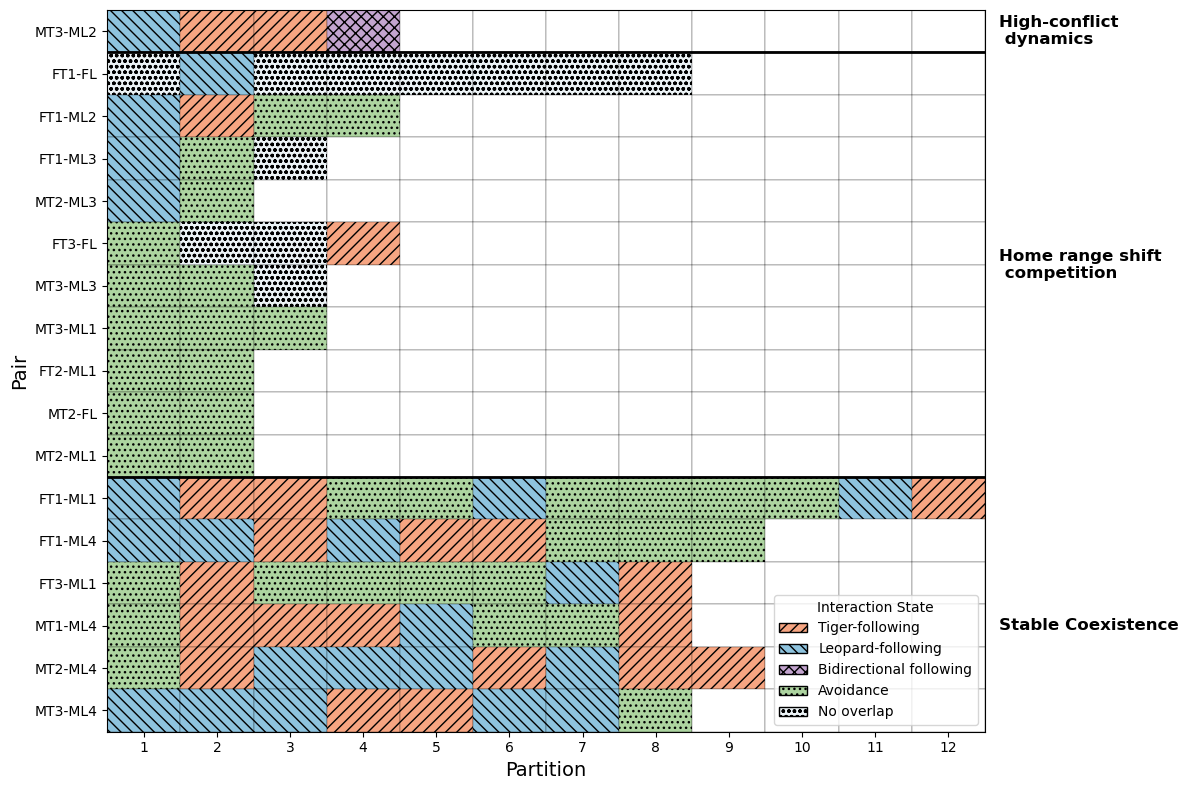

In [73]:
from matplotlib.patches import Patch
# Plot with textures
fig, ax = plt.subplots(figsize=(12, 8))
for i in range(len(pairs)):
    for j in range(len(slices)):
        pattern = df_summary.loc[i, slices[j]]
        style = pattern_styles[pattern]
        rect = plt.Rectangle((j, i), 1, 1, facecolor=style["color"], hatch=style["hatch"], edgecolor='k', linewidth = 0.2)
        ax.add_patch(rect)

# Set axis ticks and labels
ax.set_xticks(np.arange(len(slices)) + 0.5)
ax.set_xticklabels([str(int(s.replace("Slice ", "")) + 1) for s in slices])
ax.set_yticks(np.arange(len(pairs)) + 0.5)
ax.set_yticklabels(pairs)
ax.set_xlim(0, len(slices))
ax.set_ylim(0, len(pairs))


# Invert y-axis to match table order
ax.invert_yaxis()

# Create legend with hatches
legend_elements = [Patch(facecolor=style["color"], hatch=style["hatch"], edgecolor='k', label=pattern) 
                   for pattern, style in pattern_styles.items() if pattern is not None]
ax.legend(handles=legend_elements, loc='lower right', title="Interaction State")

ax.set_xlabel("Partition", fontsize= 14)
ax.set_ylabel("Pair", fontsize= 14)
# ax.set_title("Interaction Patterns by Pair and Slice (with Textures)")

# --- Add category labels ---
ax.text(len(slices) + 0.2, 0.5, "High-conflict \n dynamics", va="center", ha="left", fontsize=12, fontweight="bold")

ax.text(len(slices) + 0.2, (2+10-1)/2 + 0.5, "Home range shift \n competition", 
        va="center", ha="left", fontsize=12, fontweight="bold")

ax.text(len(slices) + 0.2, (12+len(pairs)-1)/2 + 0.5, "Stable Coexistence", 
        va="center", ha="left", fontsize=12, fontweight="bold")

# --- Add dividing lines ---
# line under row 1 (after "High-conflict")
ax.hlines(1, 0, len(slices), colors="black", linewidth=2)

# line under row 11 (after "Home range shift competition")
ax.hlines(11, 0, len(slices), colors="black", linewidth=2)

plt.tight_layout()
plt.savefig(f"../../figure/Overall_description.jpg", dpi=500, bbox_inches='tight')
plt.show()